## Directory Structure
PLEASE make sure your directory looks like this:
- root_dir
    - pixel-nerf (clone/pull from github)
    - adaptive-volume-rendering (clone/pull from github)
        - 6S980_Project.ipynb
    - scene-representation-networks (clone/pull from github)
    - data
    - checkpoints
    - ......
    
Then set your pwd to root_dir

## Relevant Repos

- PixelNeRF repo: https://github.com/sxyu/pixel-nerf

- SRN repo: https://github.com/vsitzmann/scene-representation-networks

- SRN raymarcher algorithm: https://github.com/vsitzmann/scene-representation-networks/blob/master/custom_layers.py

## Data

- Currently using cars dataset from SRN

## What we did

- Now the pixelnerf with pretrained weights are running!


## Questions
- PixelNeRF currently does: evenly coarse sampling - fine sampling via importance weights - fine sampling around expected depth. With adaptive procedure, what is a fair comparison?

## TODOs
- First attempt: let LSTM interact with the features, do 10 steps, then directly output a color
- Second attempt: sample points around the final location and do volume integral
- Check dataloader stop iteration issue (need to re-use the data)

In [1]:
root_dir = "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"       # This is the only thing you need to change.
%cd "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"

# root_dir = "/Users/jameszli/desktop/MIT/6.S980/"       # This is the only thing you need to change.
# %cd "/Users/jameszli/desktop/MIT/6.S980/"

# # Install everything
# %pip install -r adaptive-volume-rendering/requirements.txt

# Import everything
import sys

sys.path.insert(0, f"{root_dir}/scene-representation-networks/")
sys.path.insert(0, f"{root_dir}/pixel-nerf/src/")
sys.path.insert(0, f"{root_dir}/adaptive-volume-rendering/")

from dataset import *
from models import *
from renderers import *
from trains import *
from utils import *
from model import make_model, loss

print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installed Torch version: 1.13.0
cpu


## Setup & Load Test Data

In [2]:
# Download data and weights

# Make a new directory
!mkdir data
!mkdir checkpoints

# Download Test Dataset
if not os.path.exists(f"{root_dir}data/cars_train.hdf5"):
    # Download SRNs-cars dataset
    gdown.download("https://drive.google.com/uc?id={}".format("1SBjlsizq0sFNkCZxMQh-pNRi0HyFozKb"),f"{root_dir}data/cars_train.hdf5")


## Download pretrained weights from PixelNeRF
if not os.path.exists(f"{root_dir}checkpoints/pixel_nerf_weights.zip"):
  gdown.download("https://drive.google.com/uc?id={}".format("1UO_rL201guN6euoWkCOn-XpqR2e8o6ju"),f"{root_dir}checkpoints/pixel_nerf_weights.zip")
  !unzip checkpoints/pixel_nerf_weights.zip -d checkpoints/

mkdir: data: File exists
mkdir: checkpoints: File exists


In [3]:
# # View test image
# sl = 128
# dataset = SRNsCars(root_dir,img_sidelength=sl)
# mi = next(iter(dataset))

# rgb = mi['images'].reshape(sl, sl, 3)

# plt.imshow(rgb)
# plt.show()

# print("Cam2world ", mi['cam2world'])
# print("Intrinsics ", mi['intrinsics'])
# print("Pixel coords", mi['x_pix'], mi['x_pix'].max())
# print("Scene idx", mi['idx'])


# # Below are for pixelnerf convention
# key = "4e384de22a760ef72e877e82c90c24d"


# for i in range(250):
#     observation_idx = list(str(100000 + i))
#     observation_idx[0] = '0'
#     observation_idx = "".join(observation_idx)
#     pose_path = f"{root_dir}data/cars_train/{key}/pose/{observation_idx}.txt"
#     pose = torch.from_numpy(
#                 np.loadtxt(pose_path, dtype=np.float32).reshape(4, 4)
#             )
#     #print(abs(pose[0,0] - mi['cam2world'][0,0]))
#     if abs(pose[0,0] - mi['cam2world'][0,0]) < 2e-2:
#         print(f'found it! observation number {observation_idx}')
#         print(pose)

#         rgb_path = f"{root_dir}data/cars_train/{key}/rgb/{observation_idx}.png"
#         img = imageio.imread(rgb_path)[..., :3]
#         to_tensor = transforms.ToTensor()
#         img_tensor = to_tensor(img)
#         plt.imshow(img)


In [4]:
# Checking axis alignment
# sl = 4
# print(get_opencv_pixel_coordinates(sl,sl))
# Y, X = torch.meshgrid(
#         torch.arange(sl, dtype=torch.float32),
#         torch.arange(sl, dtype=torch.float32),
#     )
# print(torch.stack((X, Y)))

## Renderer

Loading PixlNeRF models

- The volume renderer is in src/nerf.py
- Can easily wrap a net with a renderer using _RenderWrapper function
- The current volume renderer samples points in the following way:
  - Sample 64 coarse points (uniform sample)
  - Sample 16 fine points (importance sample, still need to check how)
  - Compute an expected depth, then sample 16 random normal points with sd=0.01 around that depth.

In [5]:
# ############## Original Volume renderer
# # Create a custom conf
# from pyhocon import ConfigFactory
# conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# # Create a pixelnerf net
# net = make_new_model(conf["model"]).to(device=device)
# net.stop_encoder_grad = True

# # Load pretrianed weights
# model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
# net.load_weights(model_path)

# # Combine with volumerenderer
# renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(
#     device=device
# )

# rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

# # Test dataset
# sl = 32
# train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
#                                              max_num_instances=1,
#                                              max_observations_per_instance=50,
#                                              img_sidelength=sl,
#                                              specific_observation_idcs=None,
#                                              samples_per_instance=4)



# train_dataloader = DataLoader(train_dataset,
#                                       batch_size=1,
#                                       shuffle=True,
#                                       drop_last=True,
#                                       collate_fn=train_dataset.collate_fn
#                                       )

# # Configurations
# optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         iter(train_dataloader), 
#         loss_fn=mse_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=500,
#         steps_til_summary=10
#         )
# except Exception:
#     print(traceback.format_exc())



### PixelNeRF + Raymarcher

In [6]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# Create a pixelnerf net
net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# Load pretrianed weights
model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
net.load_weights(model_path)

# Combine with volumerenderer
renderer = Raymarcher.from_conf(conf["raymarcher"]).to(
    device=device
)

rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

Using torchvision resnet34 encoder


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load /Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/checkpoints/srn_car/pixel_nerf_latest


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0: loss = 0.11221


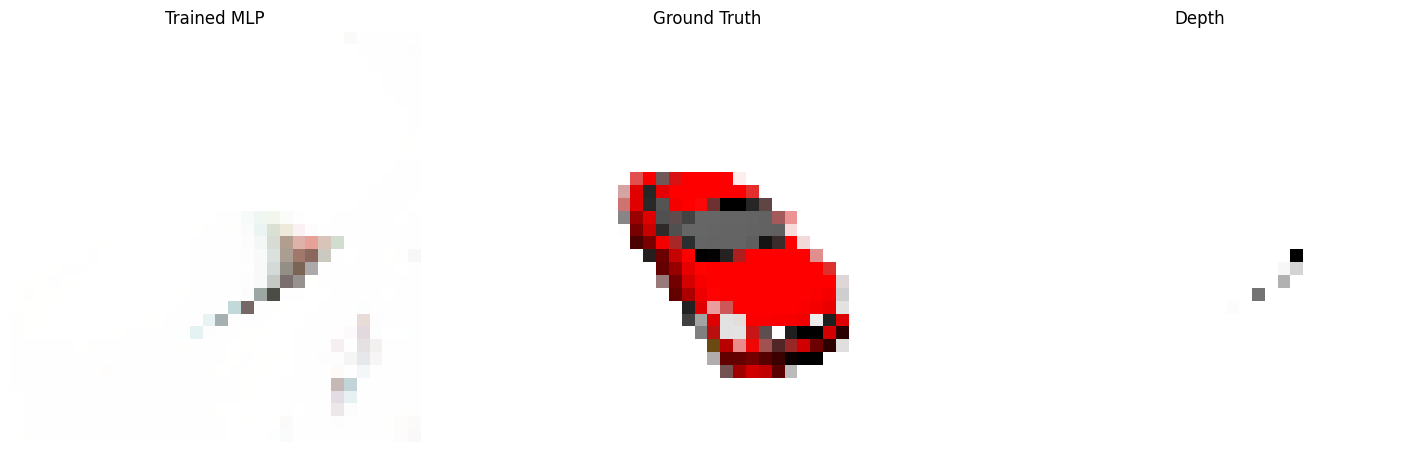

Step 10: loss = 0.11327


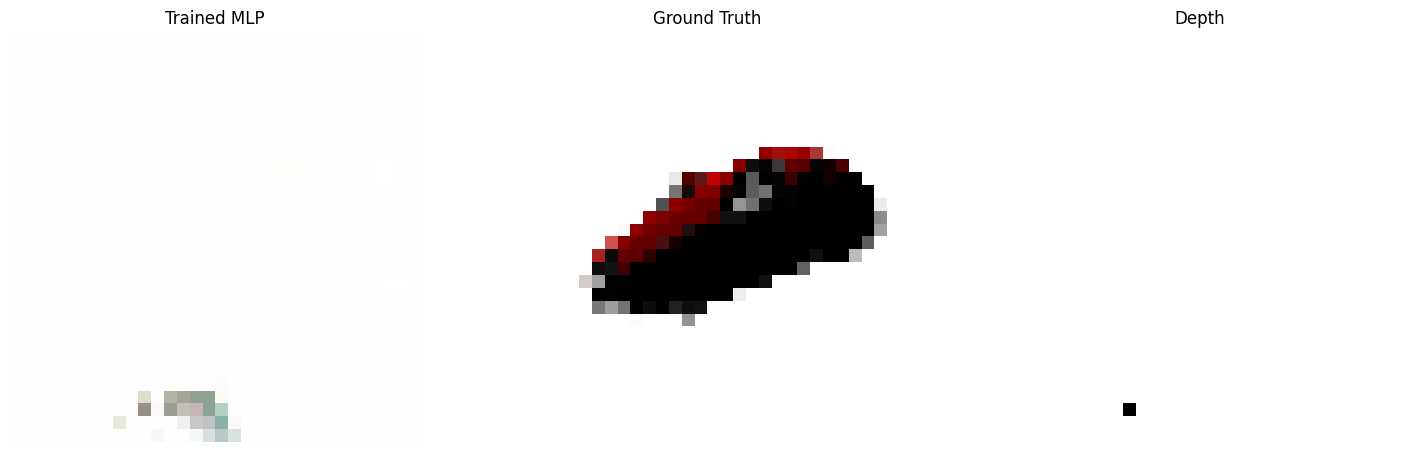

Step 20: loss = 0.08332


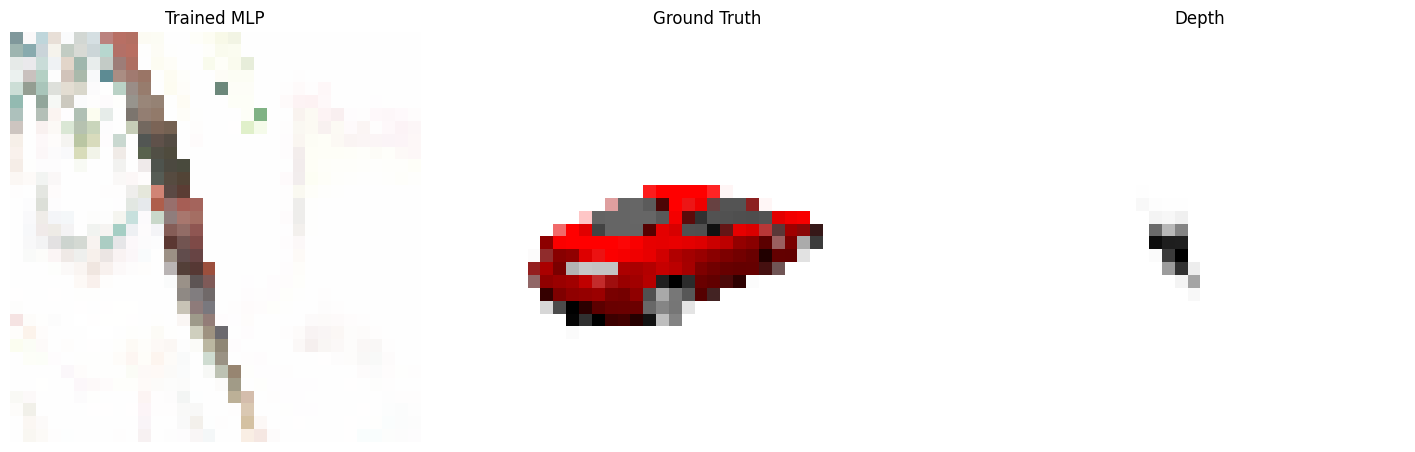

Step 30: loss = 0.06869
same view dir as src


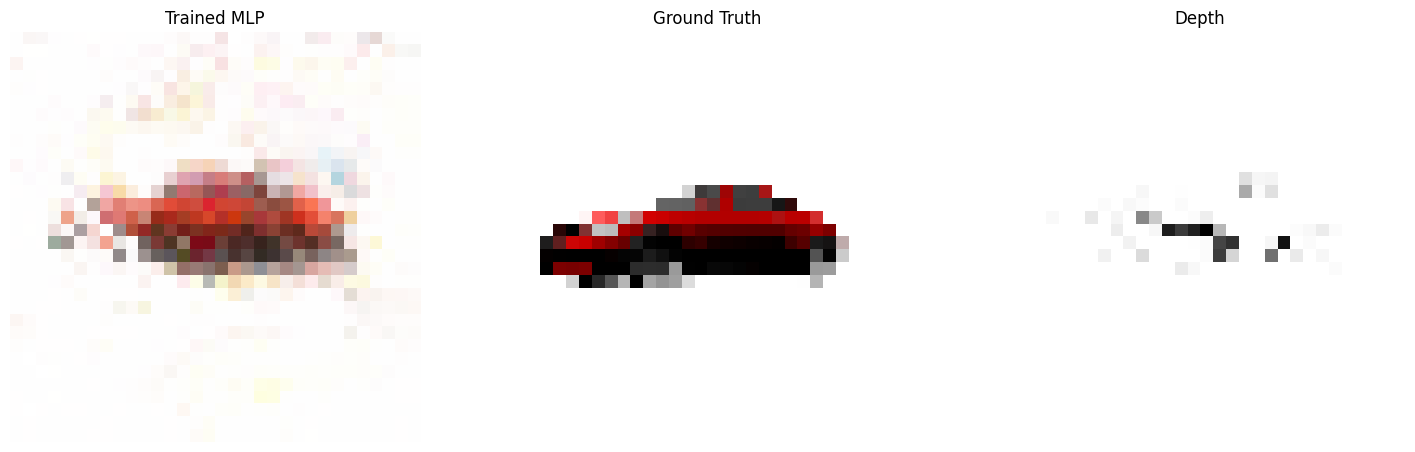

Step 40: loss = 0.06634


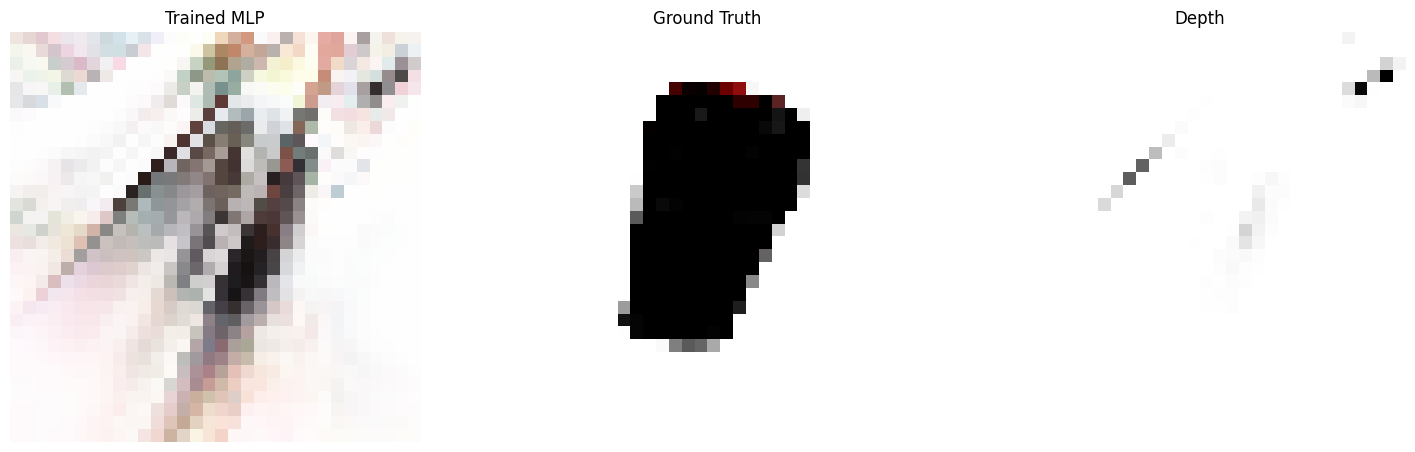

Step 50: loss = 0.08011
same view dir as src


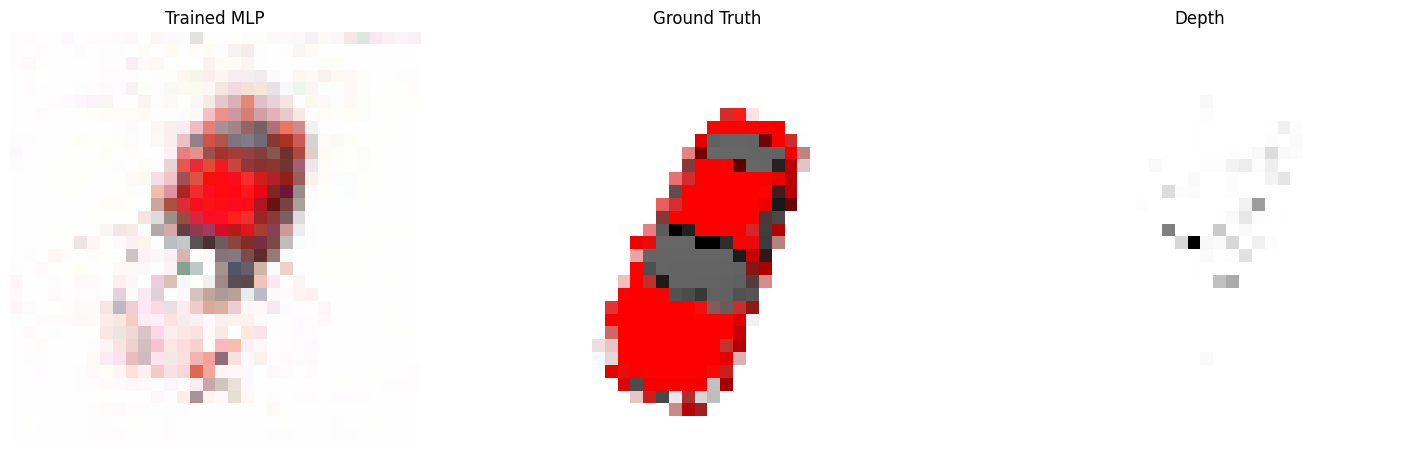

Step 60: loss = 0.06757
same view dir as src


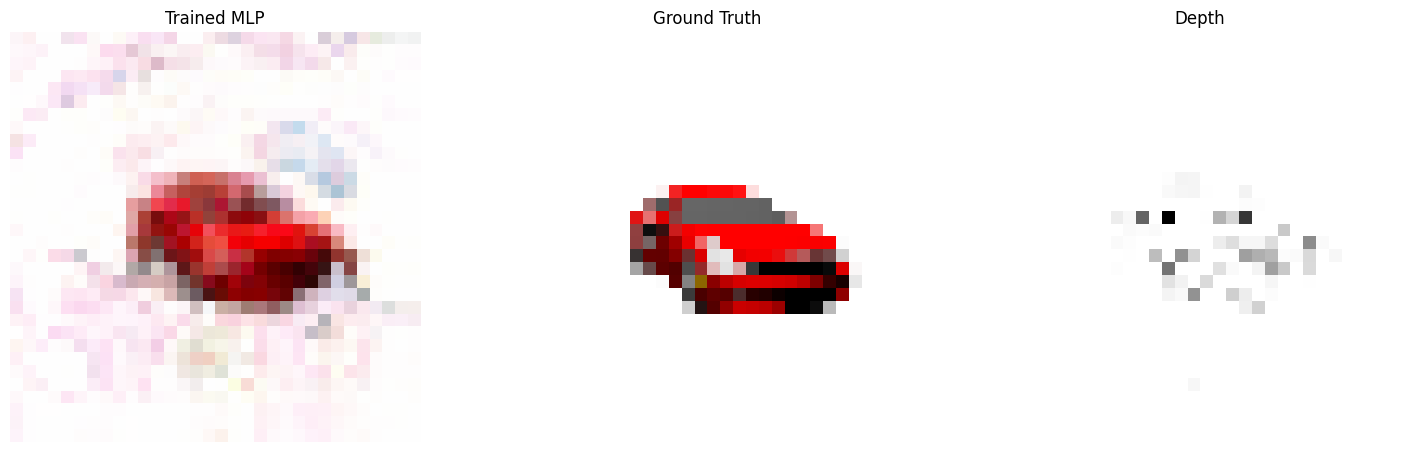

Step 70: loss = 0.06457


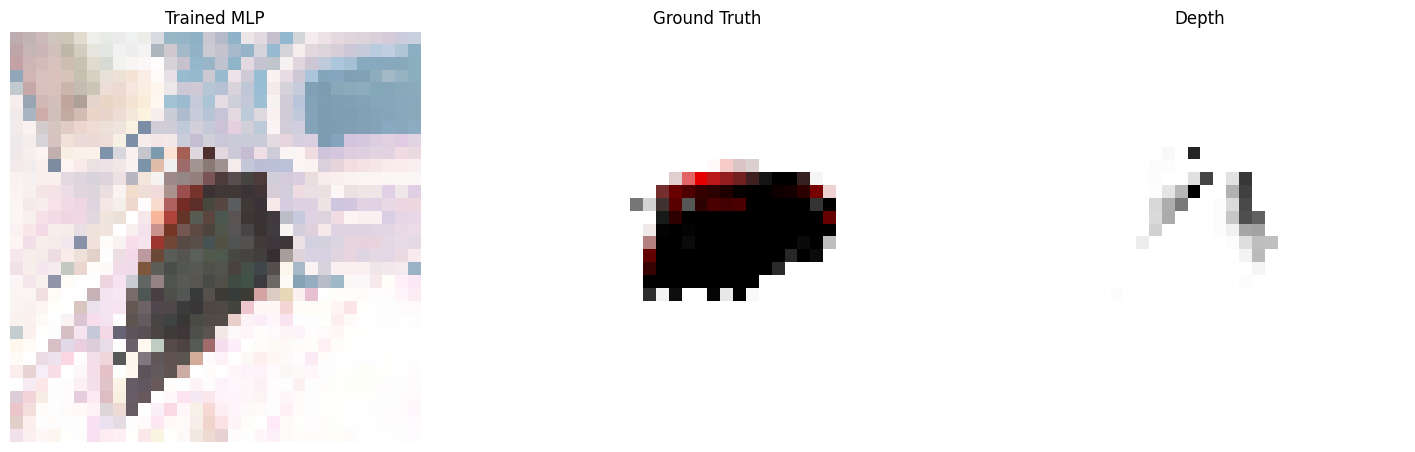

Step 80: loss = 0.03897
same view dir as src


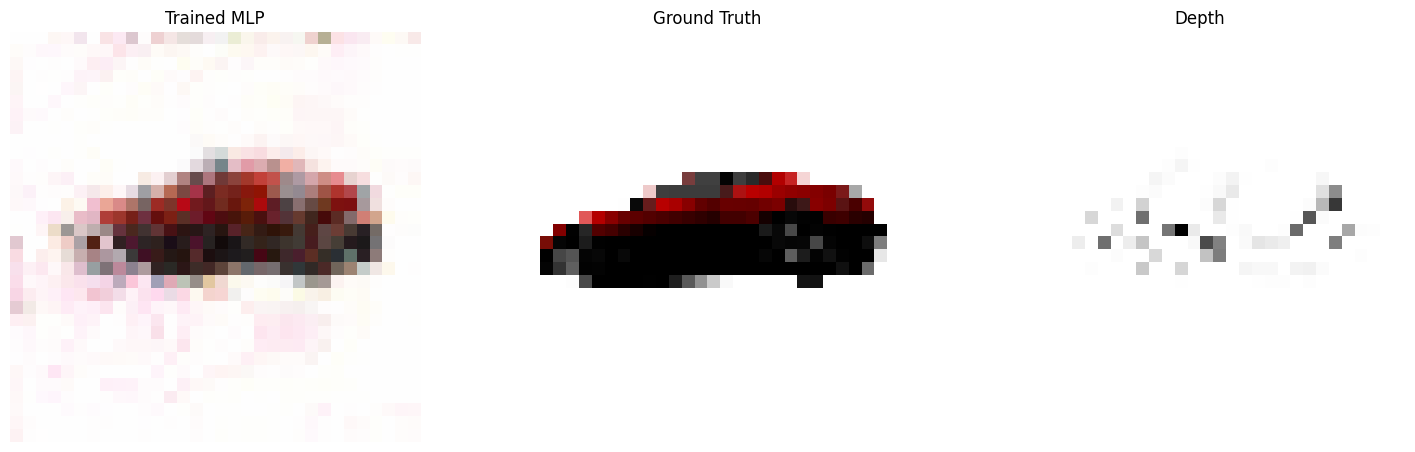

Step 90: loss = 0.04476


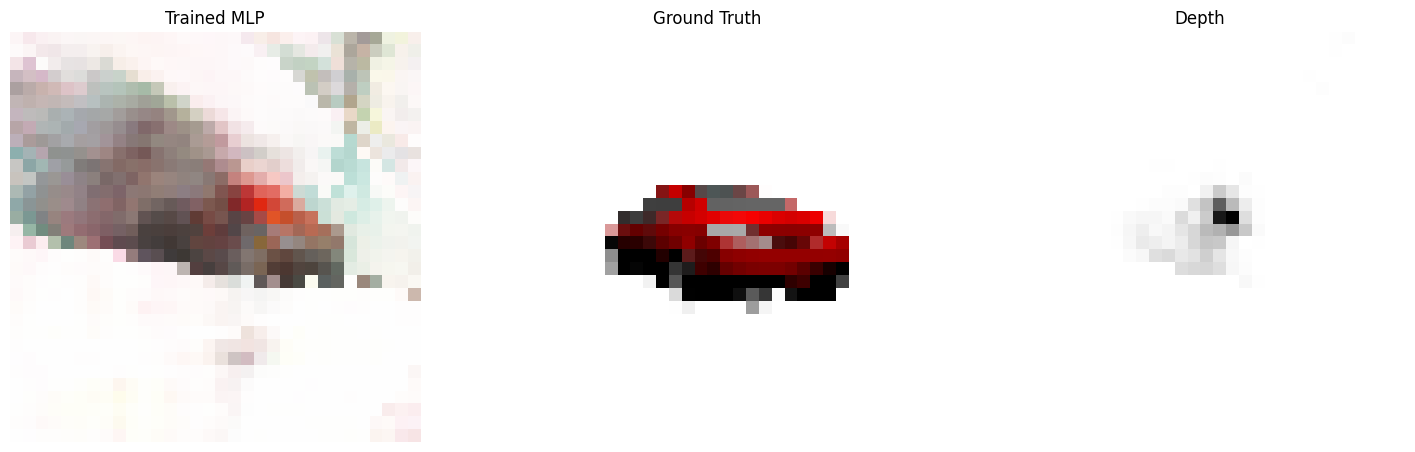

Step 100: loss = 0.05131
same view dir as src


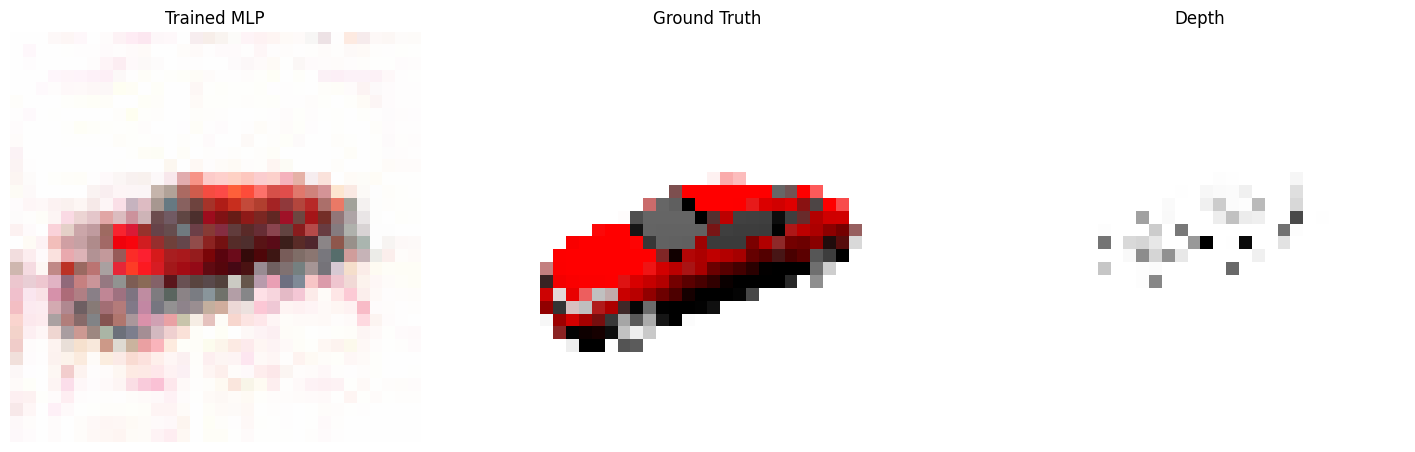

Step 110: loss = 0.09027
same view dir as src


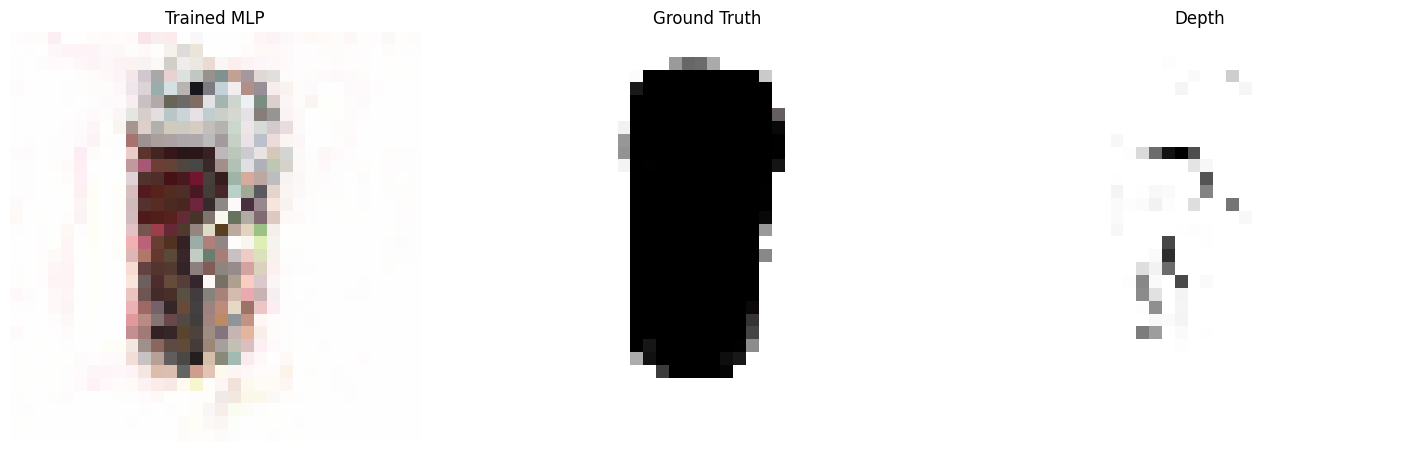

Step 120: loss = 0.06989


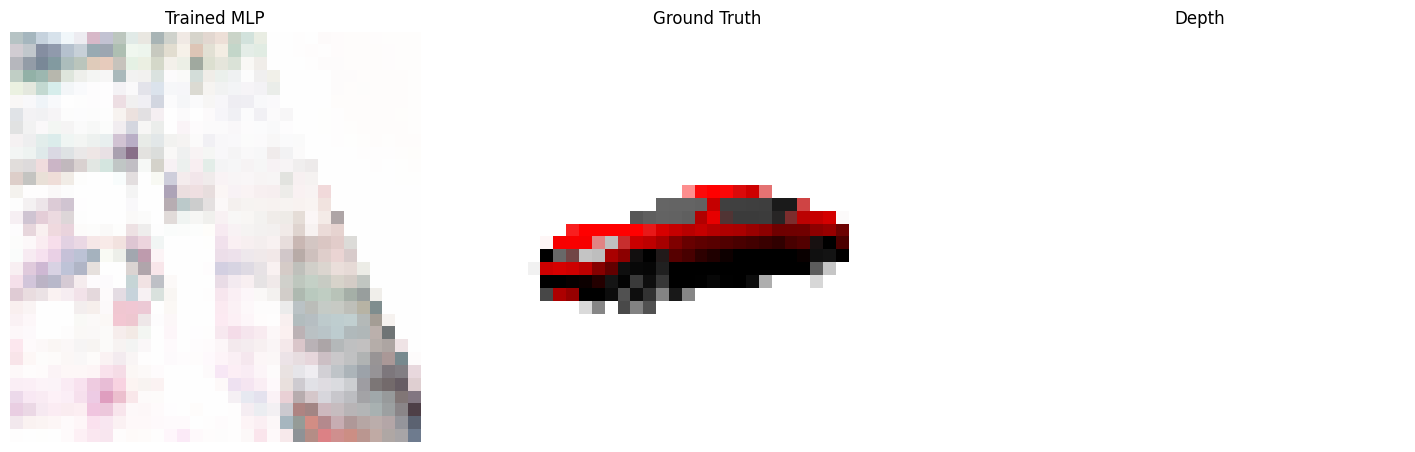

Step 130: loss = 0.04776
same view dir as src


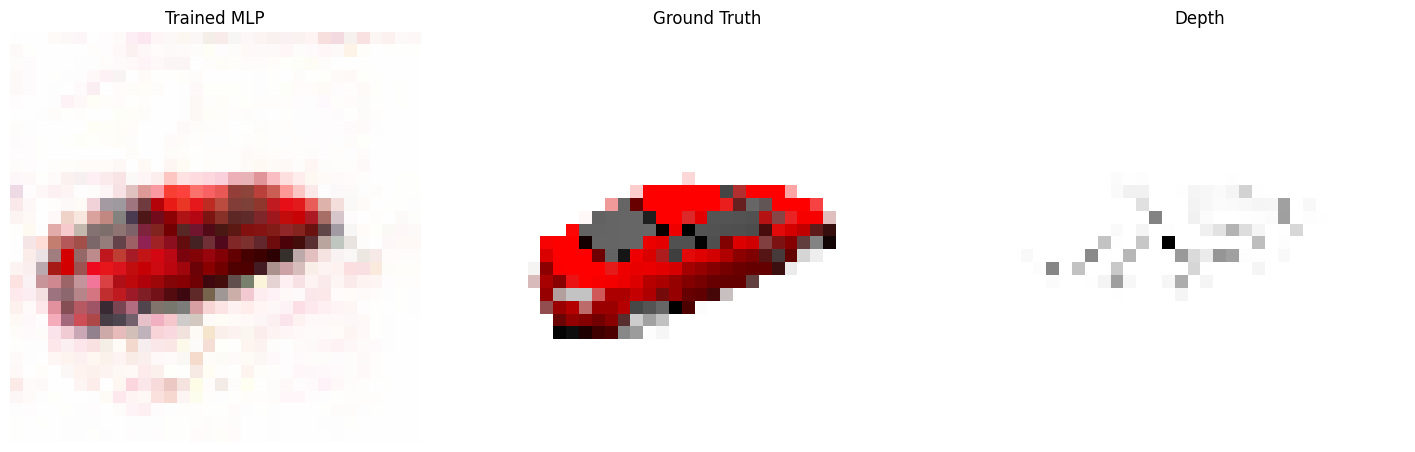

Step 140: loss = 0.06937
same view dir as src


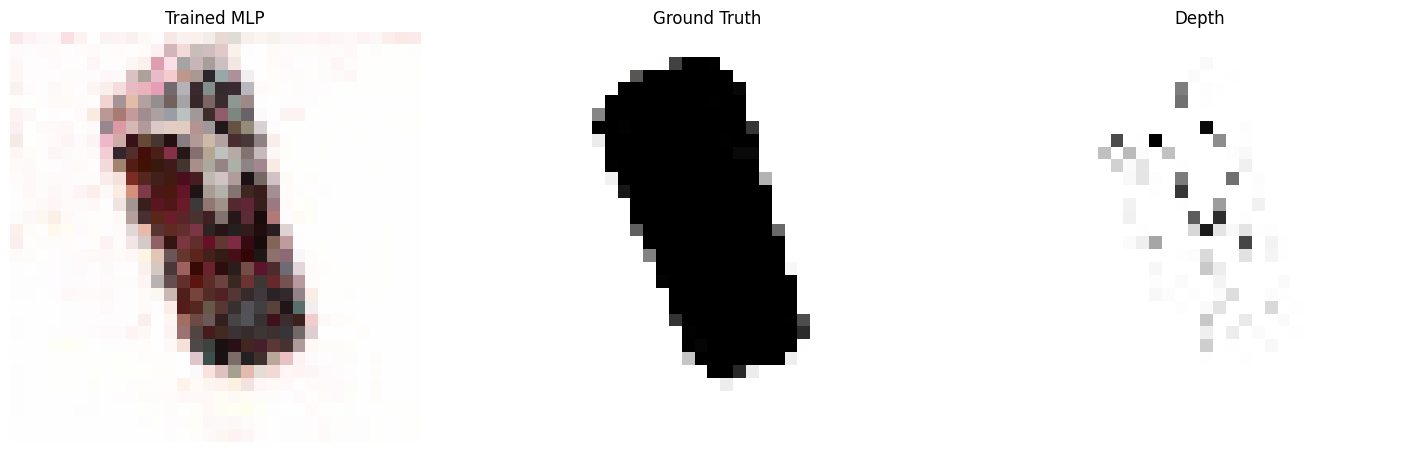

Step 150: loss = 0.05394
same view dir as src


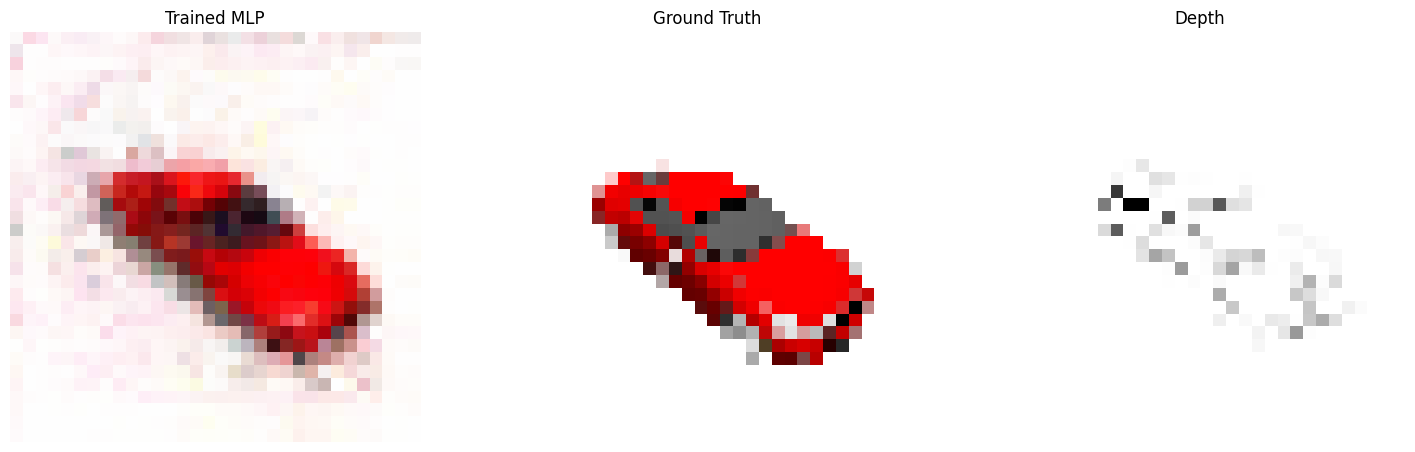

Step 160: loss = 0.04832


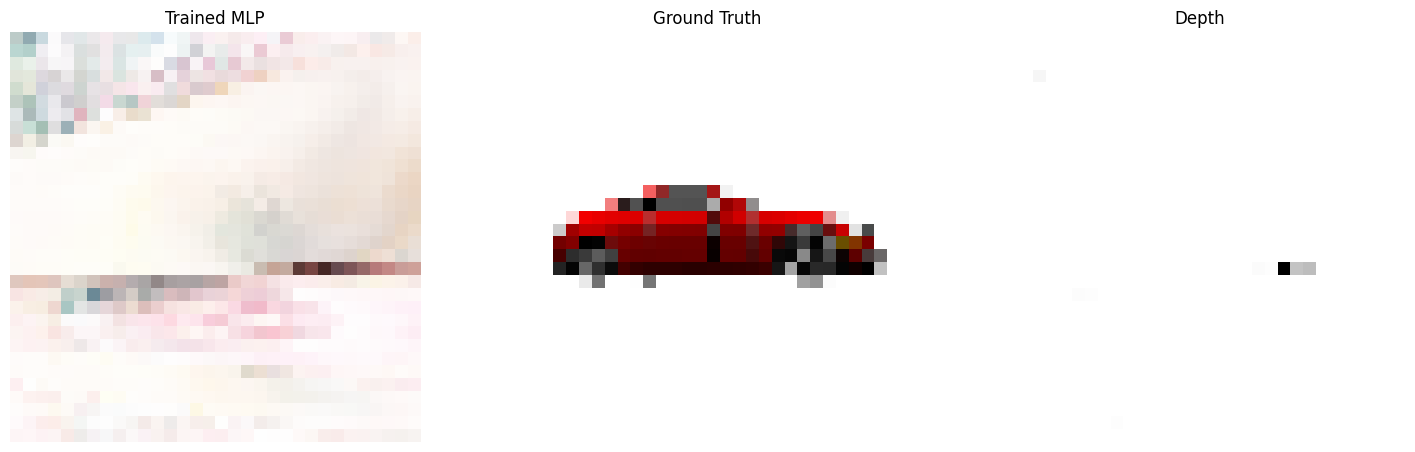

Step 170: loss = 0.06772
same view dir as src


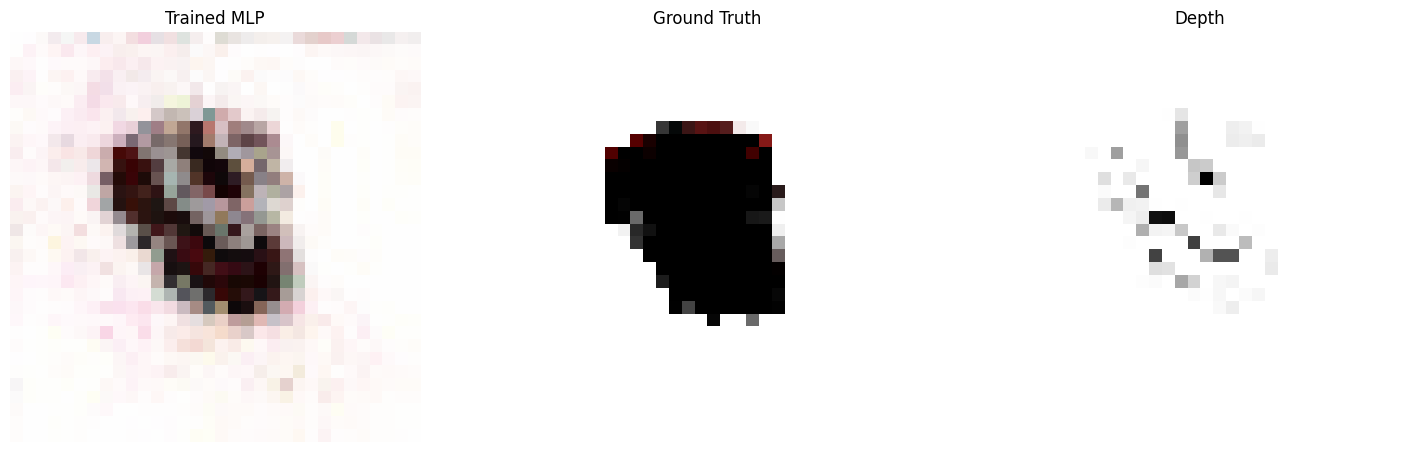

Step 180: loss = 0.09477
same view dir as src


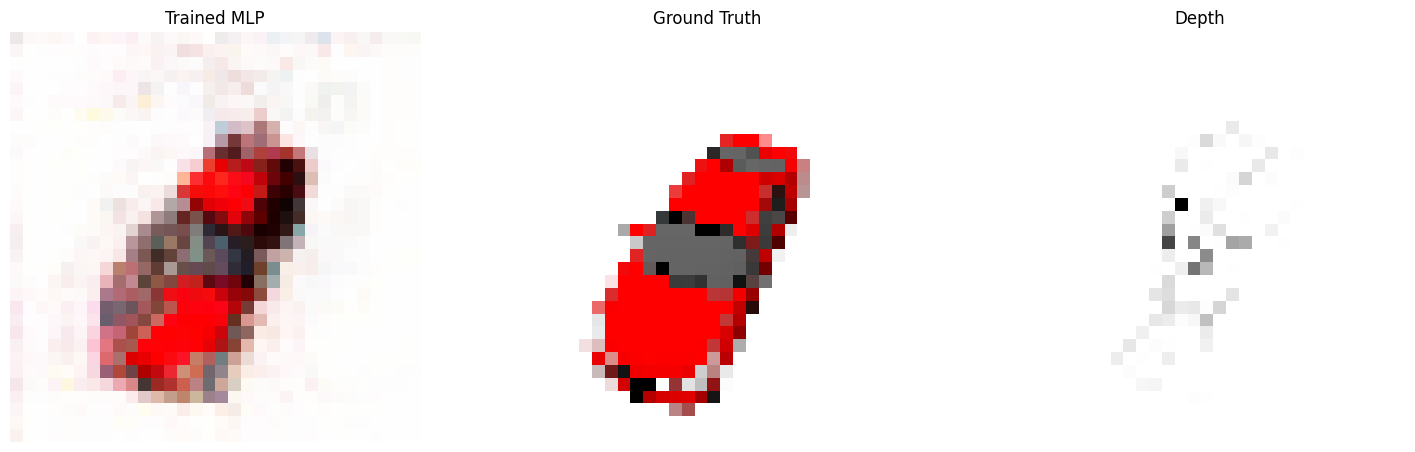

Step 190: loss = 0.07228


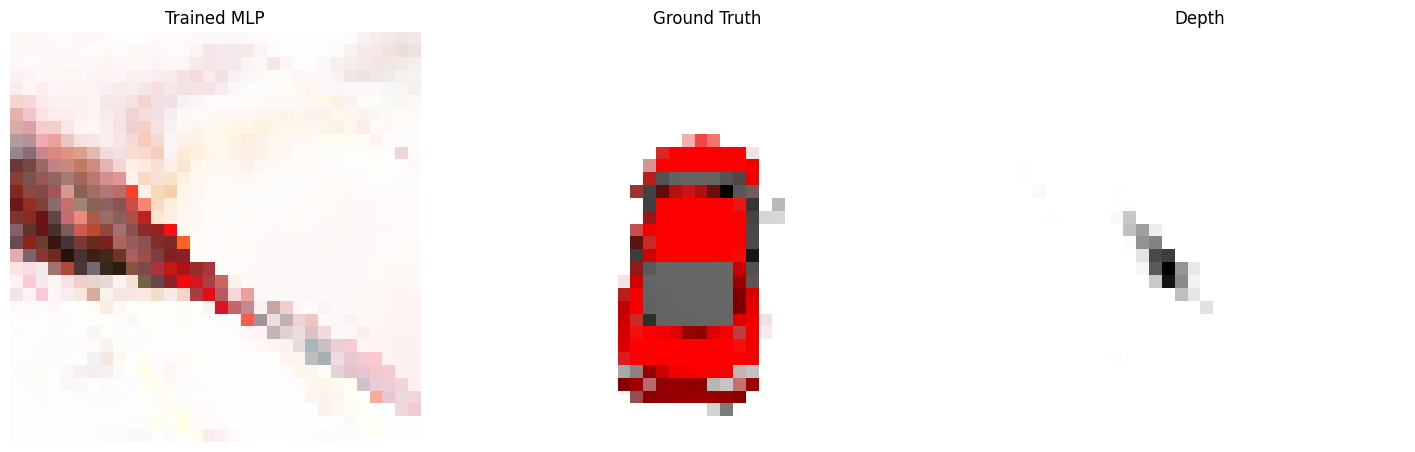

Step 200: loss = 0.05125
same view dir as src


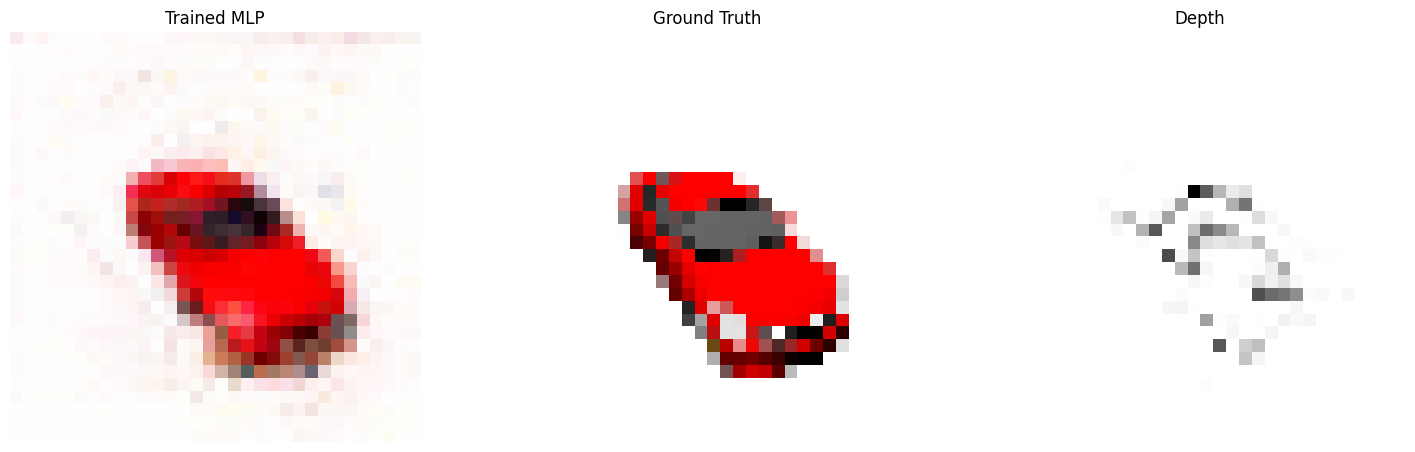

Step 210: loss = 0.01411
same view dir as src


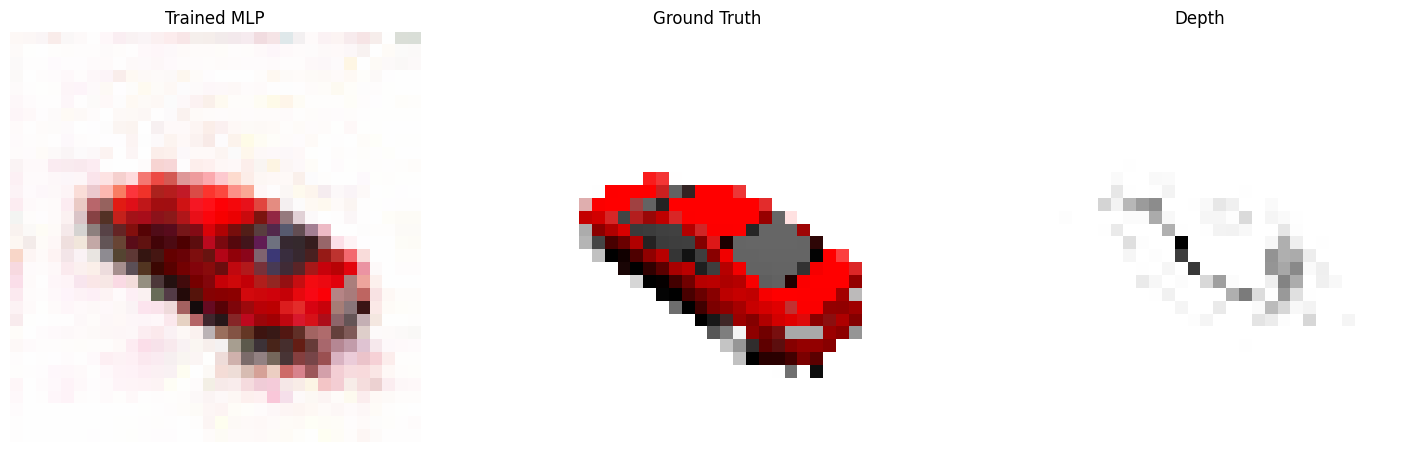

Step 220: loss = 0.07782
same view dir as src


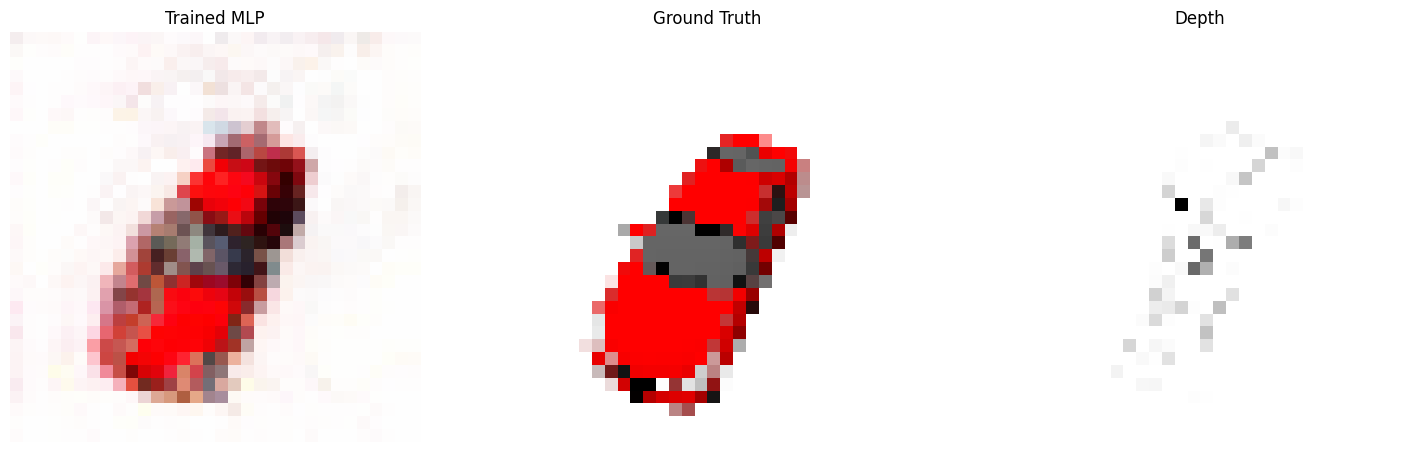

Step 230: loss = 0.04890
same view dir as src


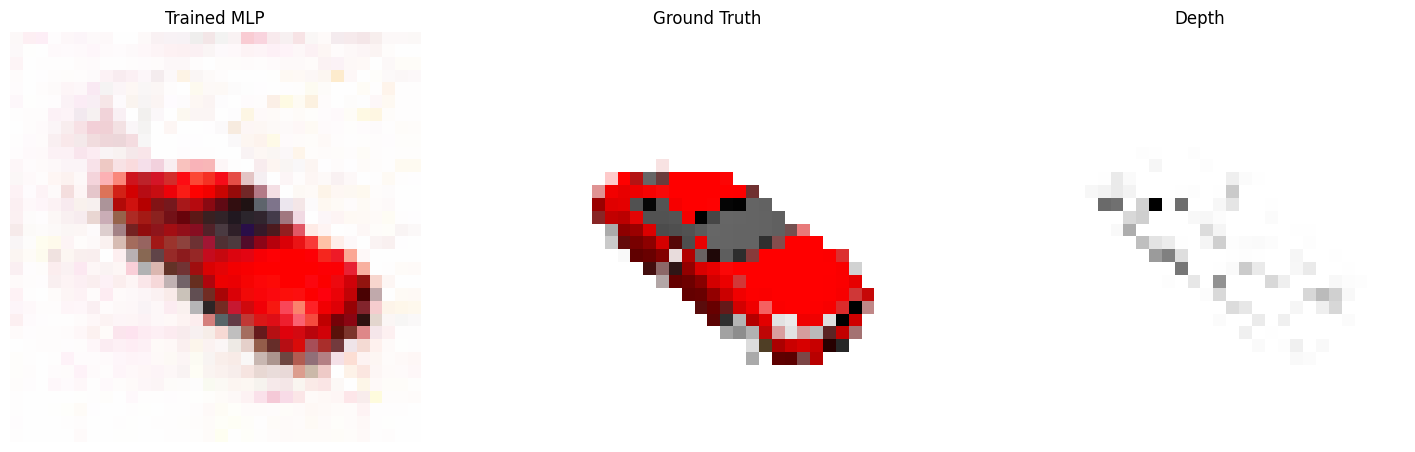

Step 240: loss = 0.06512


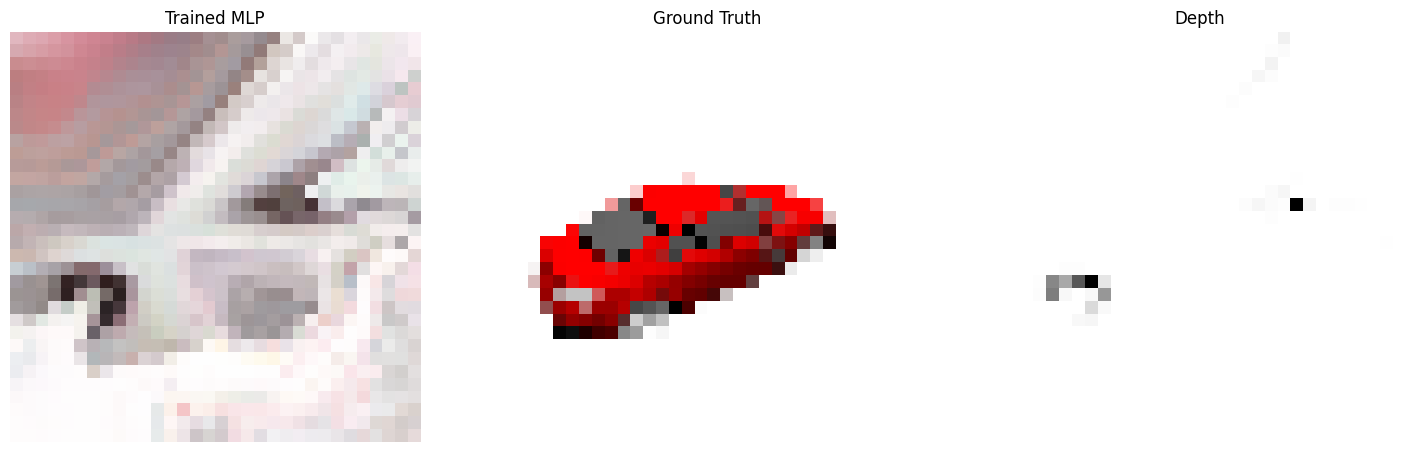

Step 250: loss = 0.06197
same view dir as src


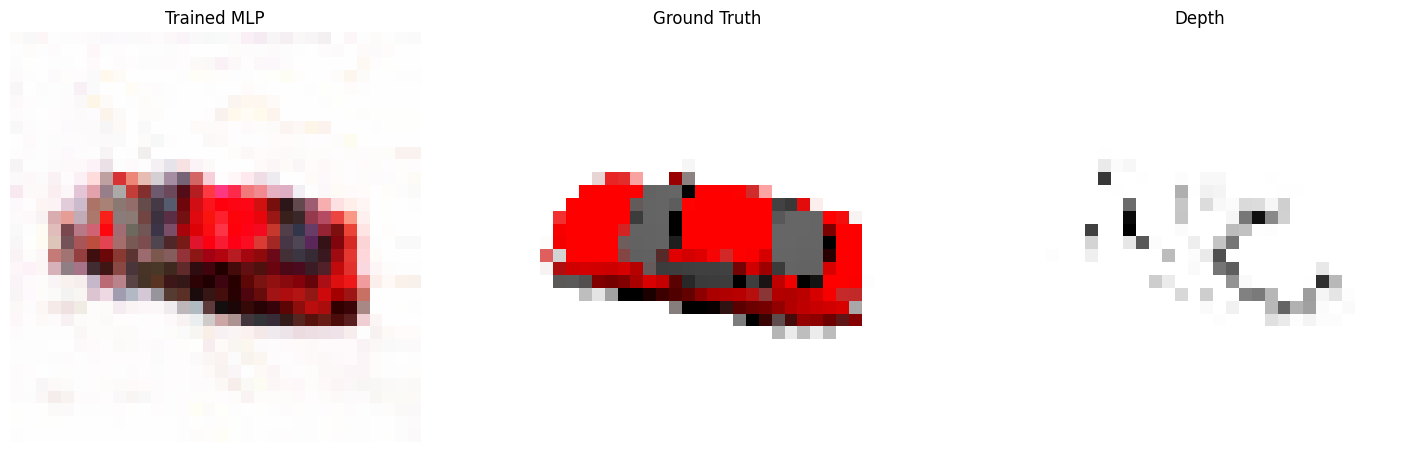

Step 260: loss = 0.09709
same view dir as src


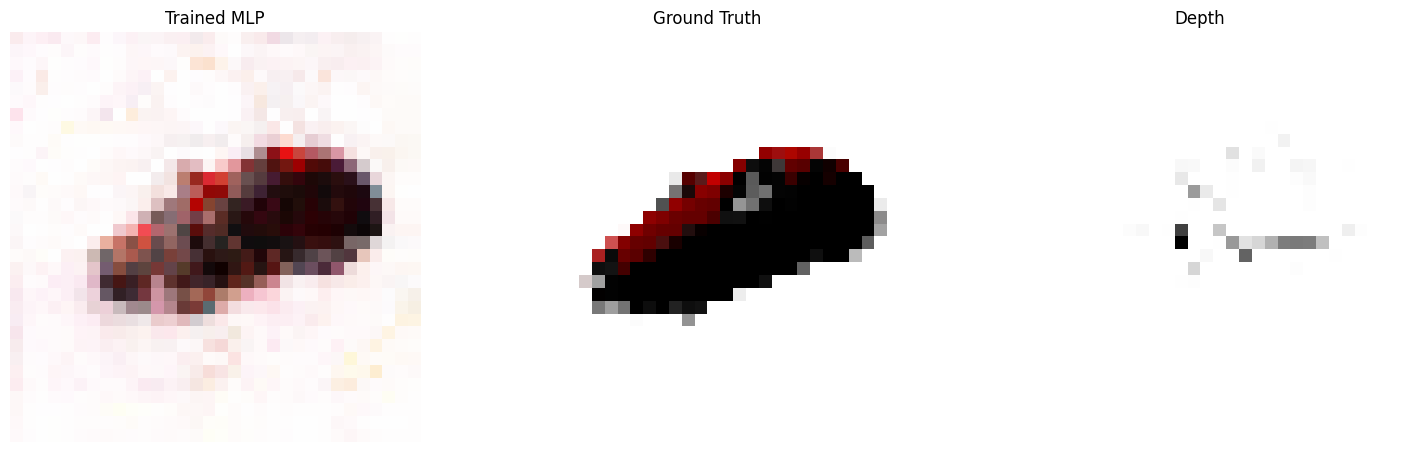

Step 270: loss = 0.04772


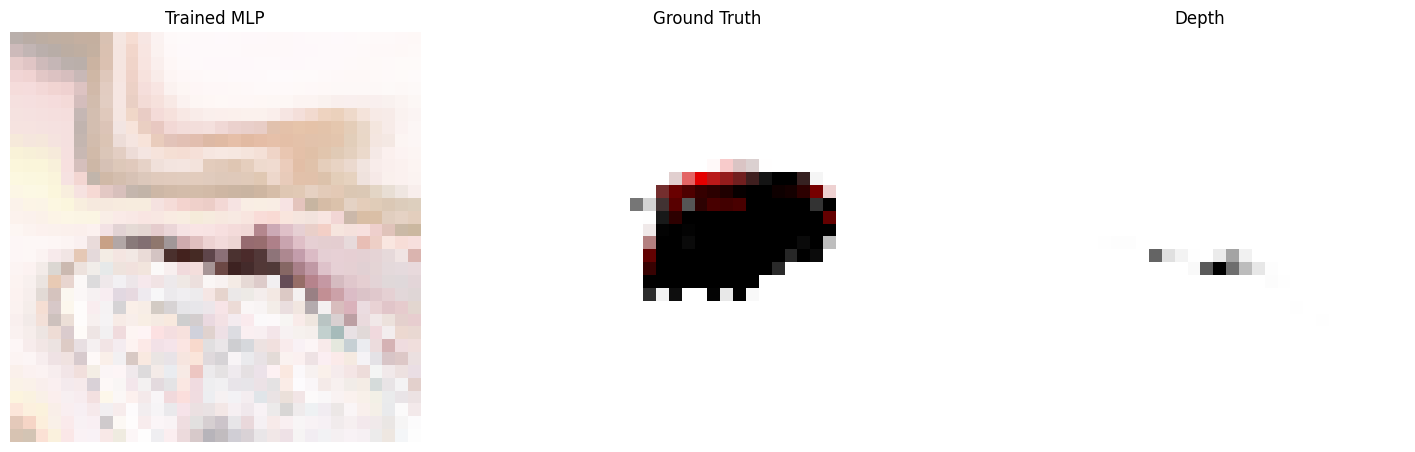

Step 280: loss = 0.06522
same view dir as src


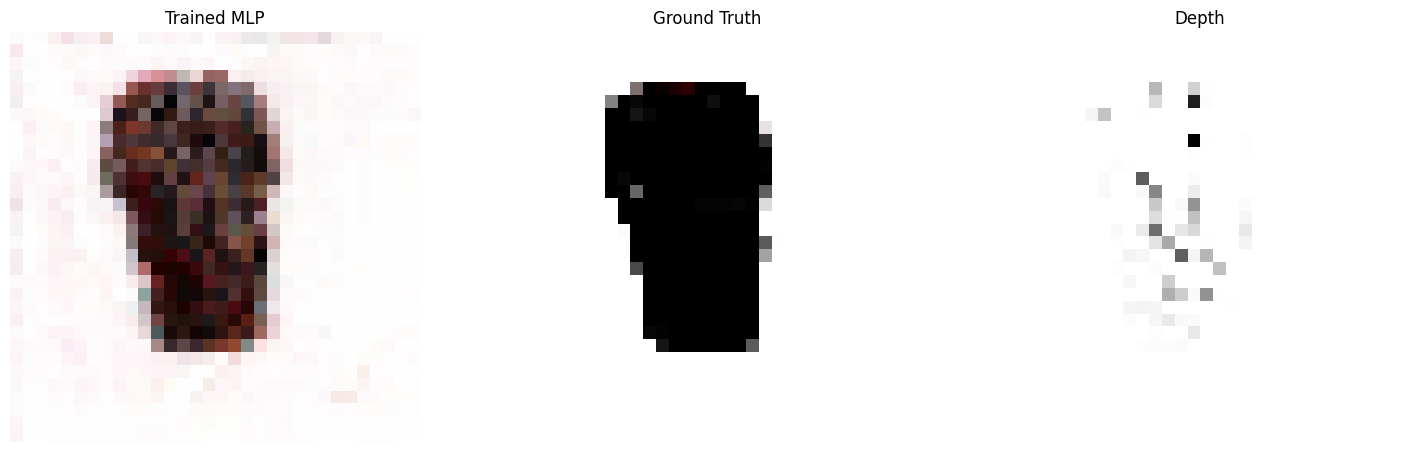

Step 290: loss = 0.06255
same view dir as src


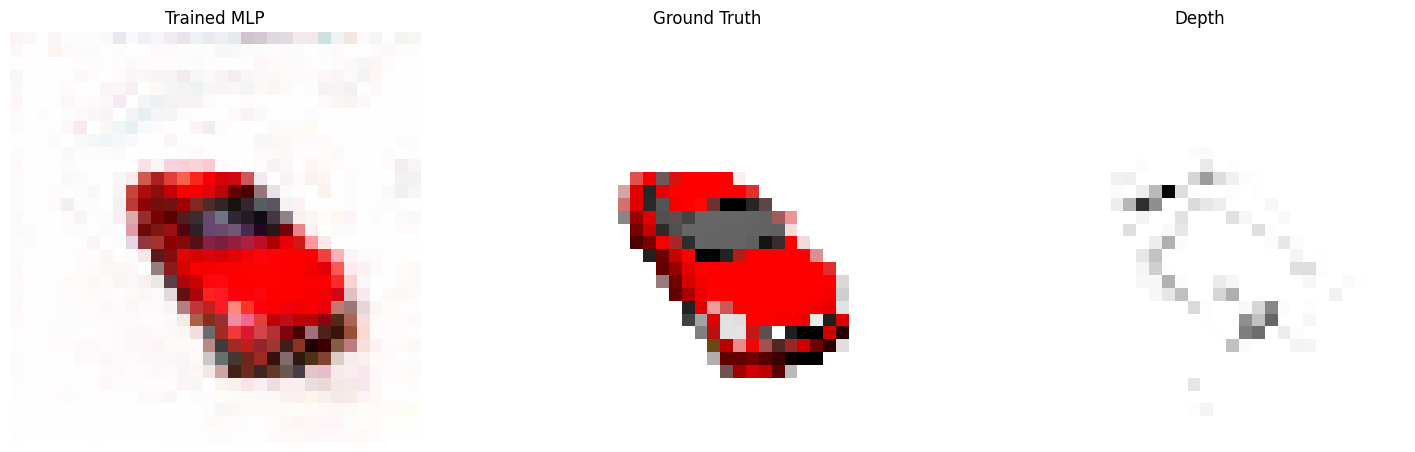

Step 300: loss = 0.05834


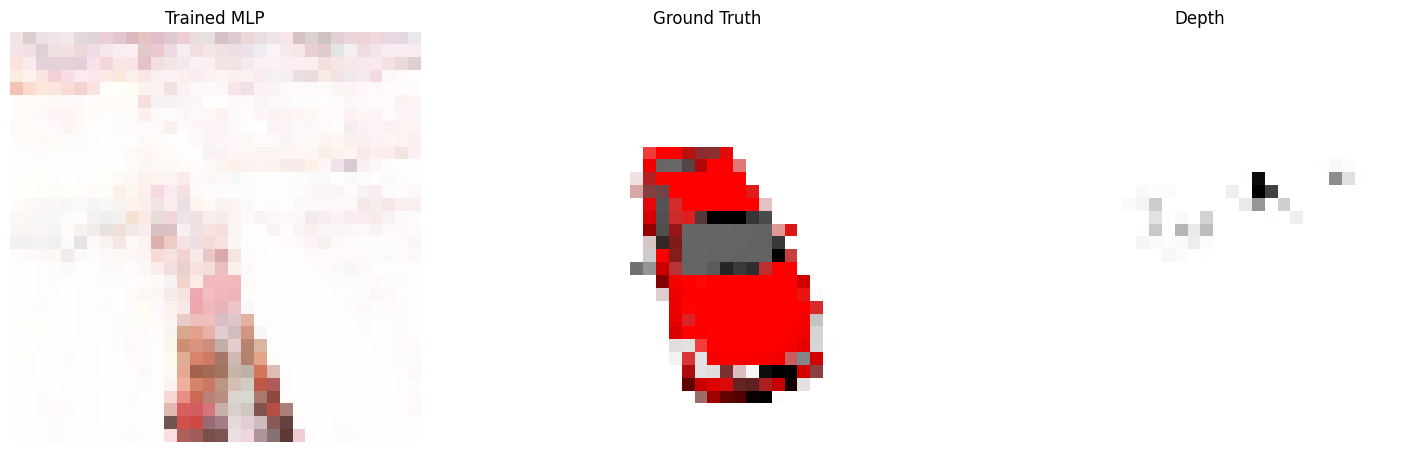

Step 310: loss = 0.05796
same view dir as src


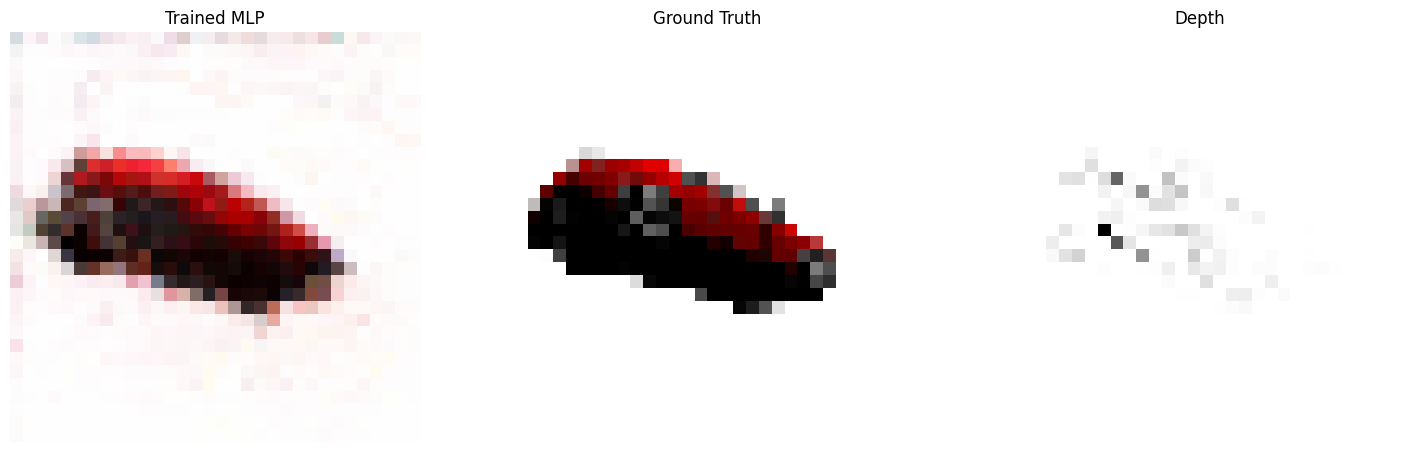

Step 320: loss = 0.08323


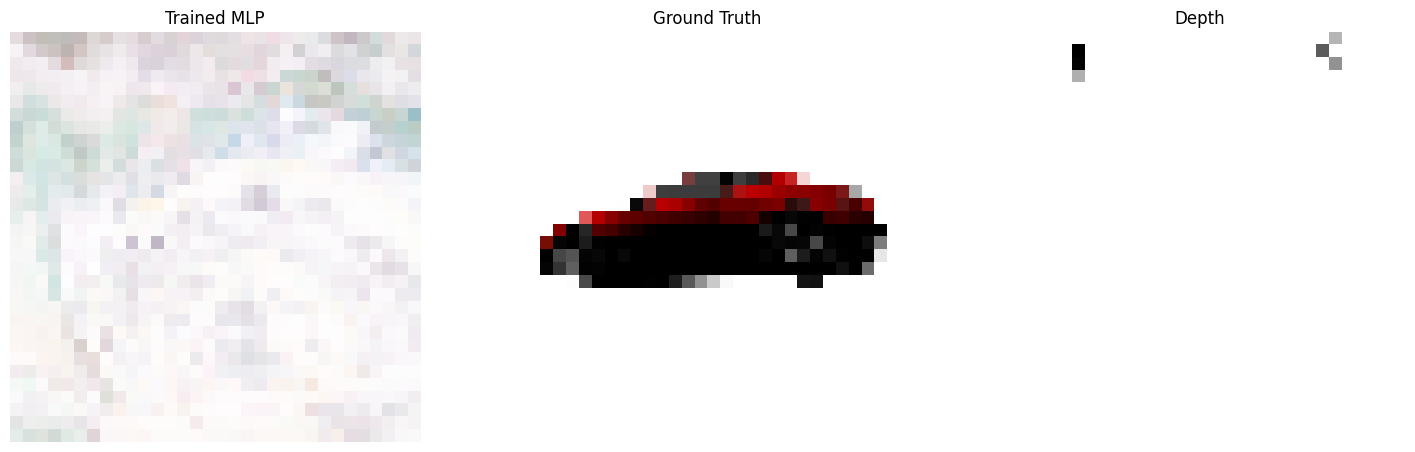

Step 330: loss = 0.04498


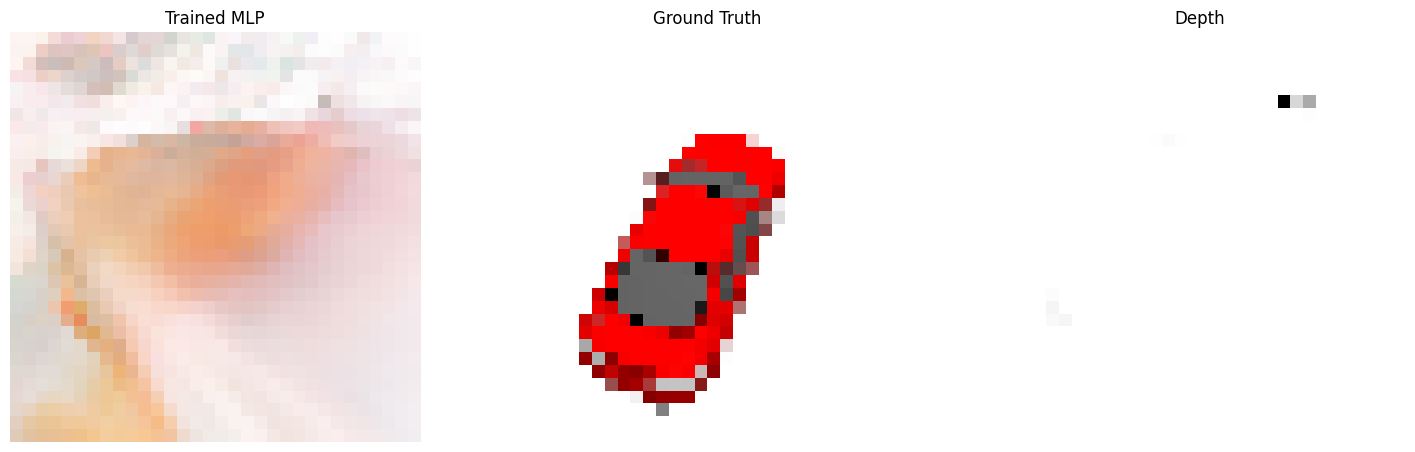

Step 340: loss = 0.06023
same view dir as src


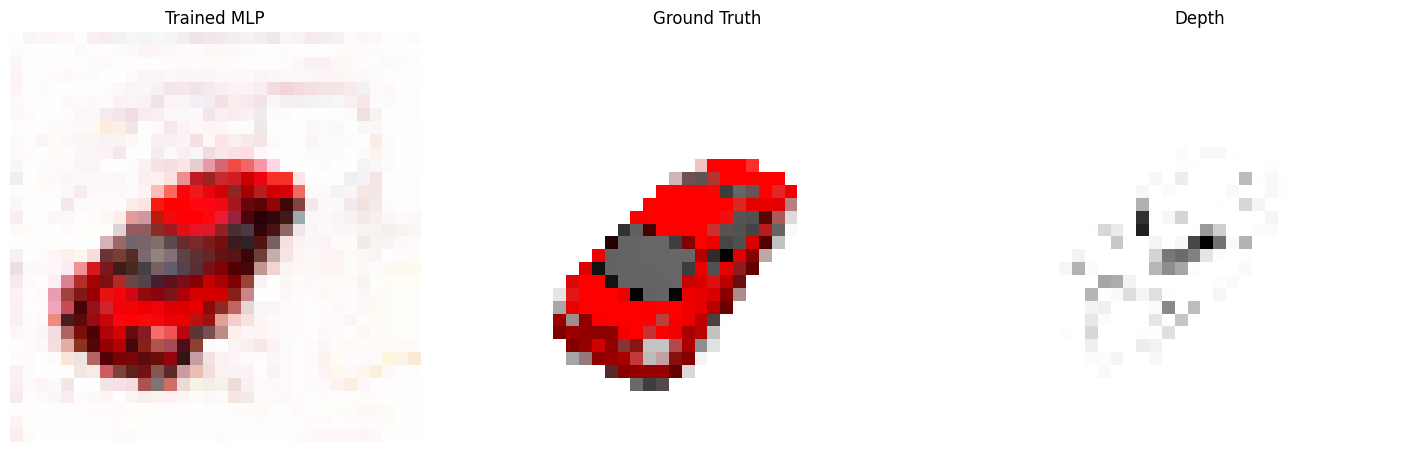

Step 350: loss = 0.07885
same view dir as src


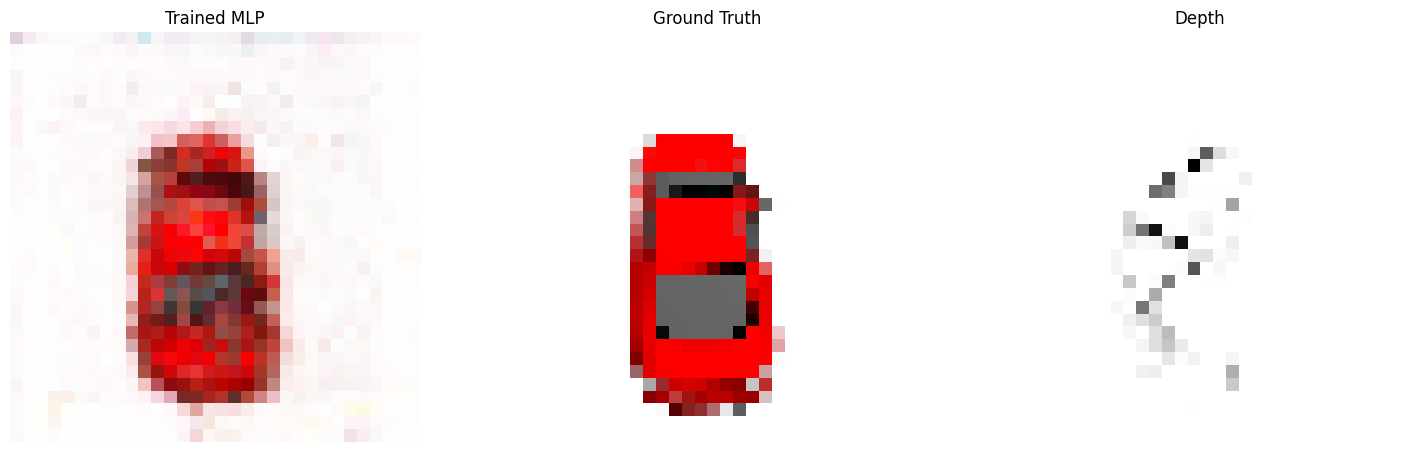

Step 360: loss = 0.04145


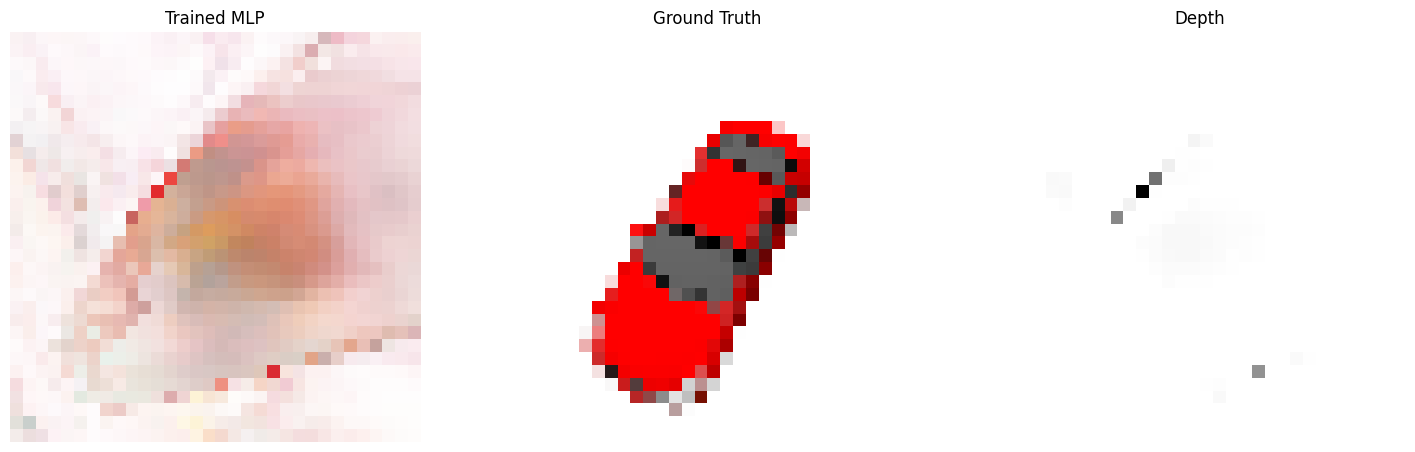

Step 370: loss = 0.05553


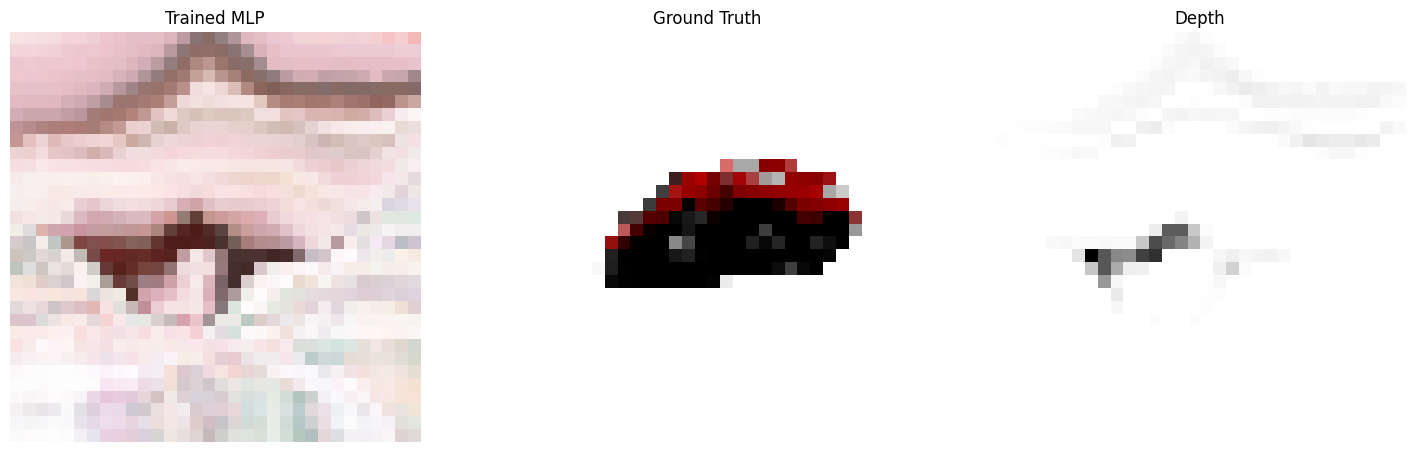

Step 380: loss = 0.06913
same view dir as src


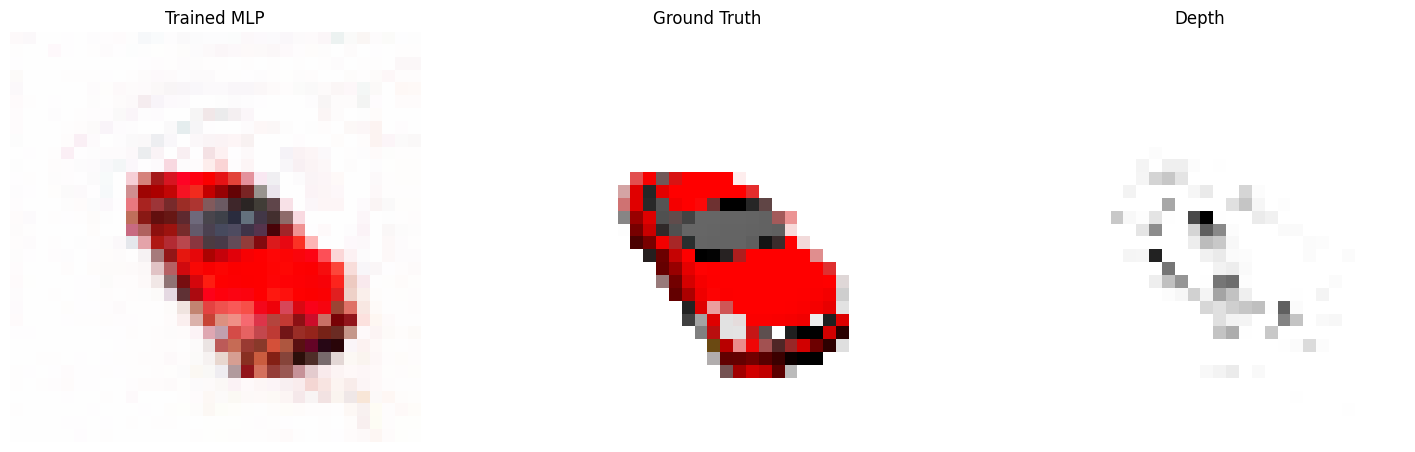

Step 390: loss = 0.07750


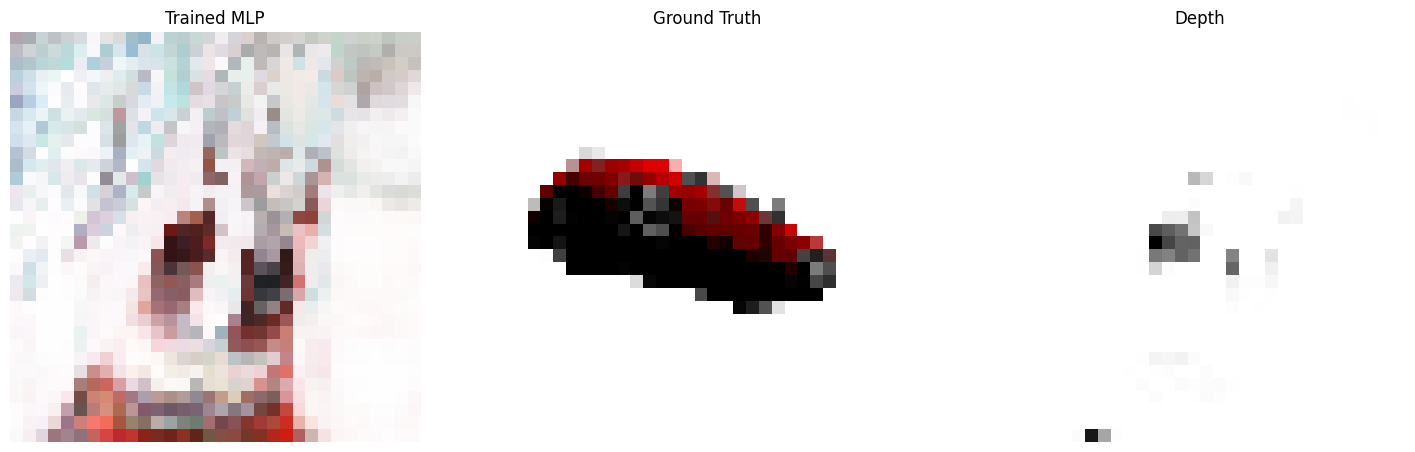

Step 400: loss = 0.07899
same view dir as src


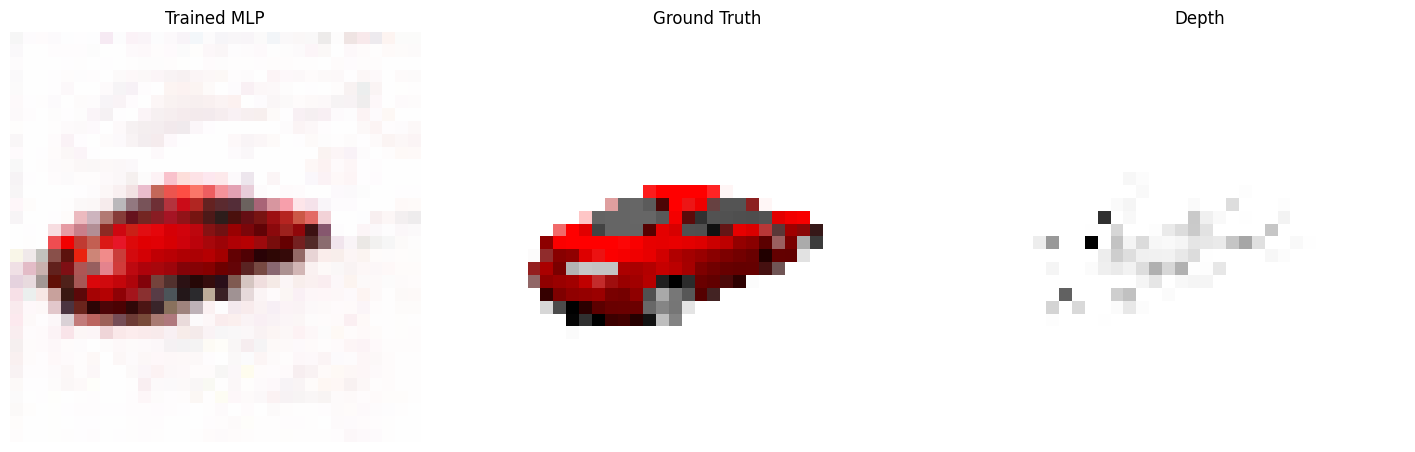

Step 410: loss = 0.05535
same view dir as src


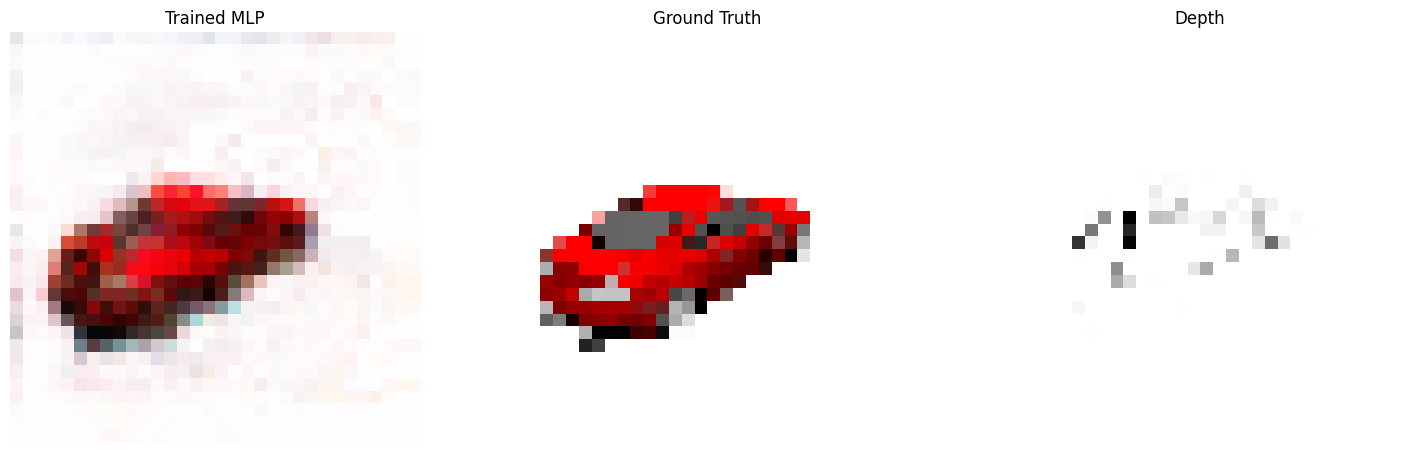

Step 420: loss = 0.09512


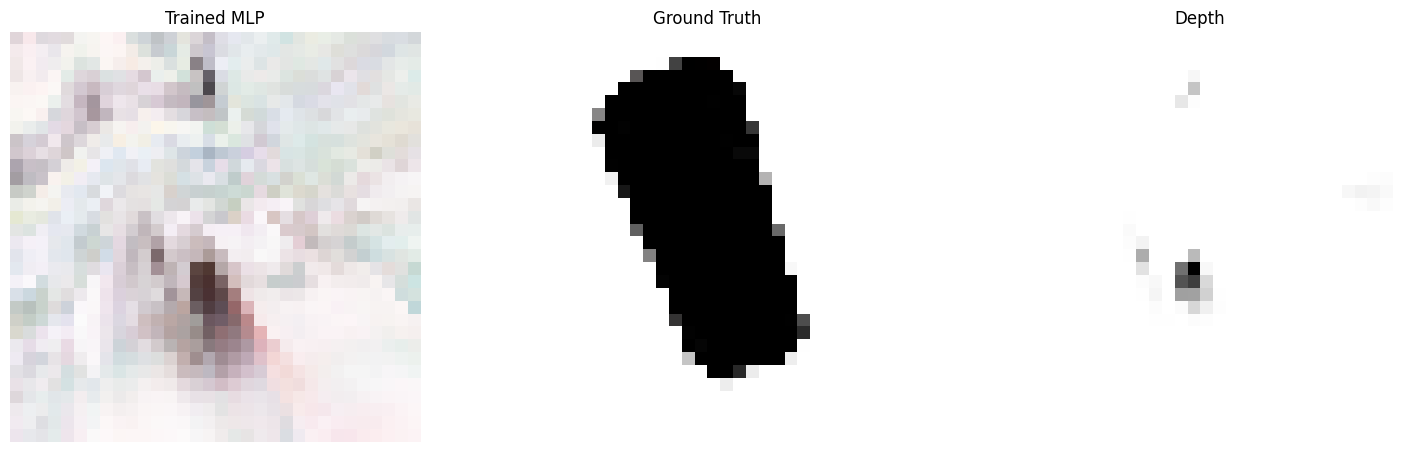

Step 430: loss = 0.03521


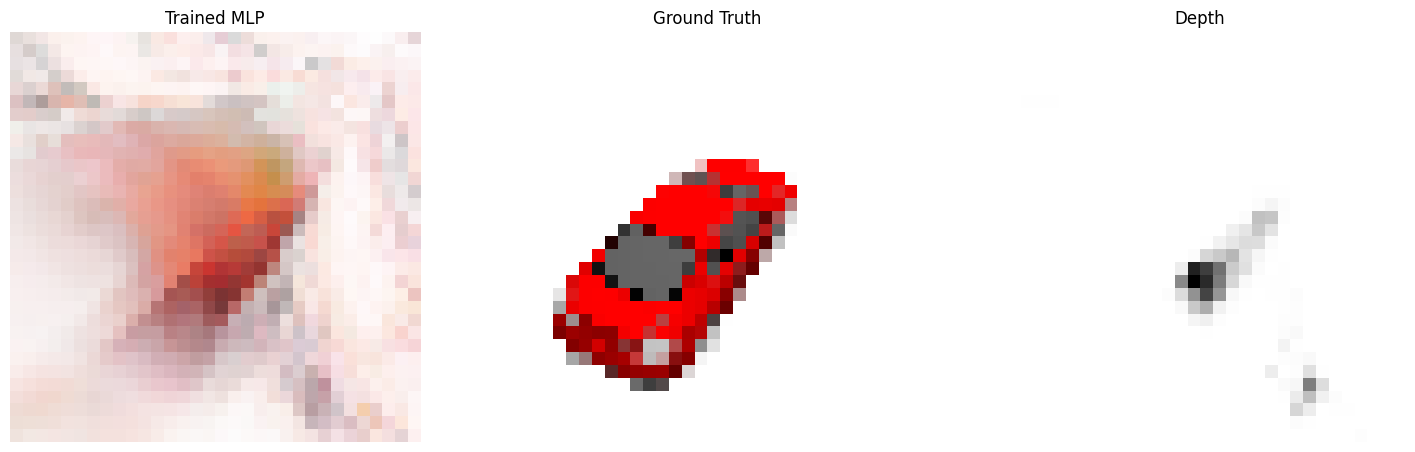

Step 440: loss = 0.08398


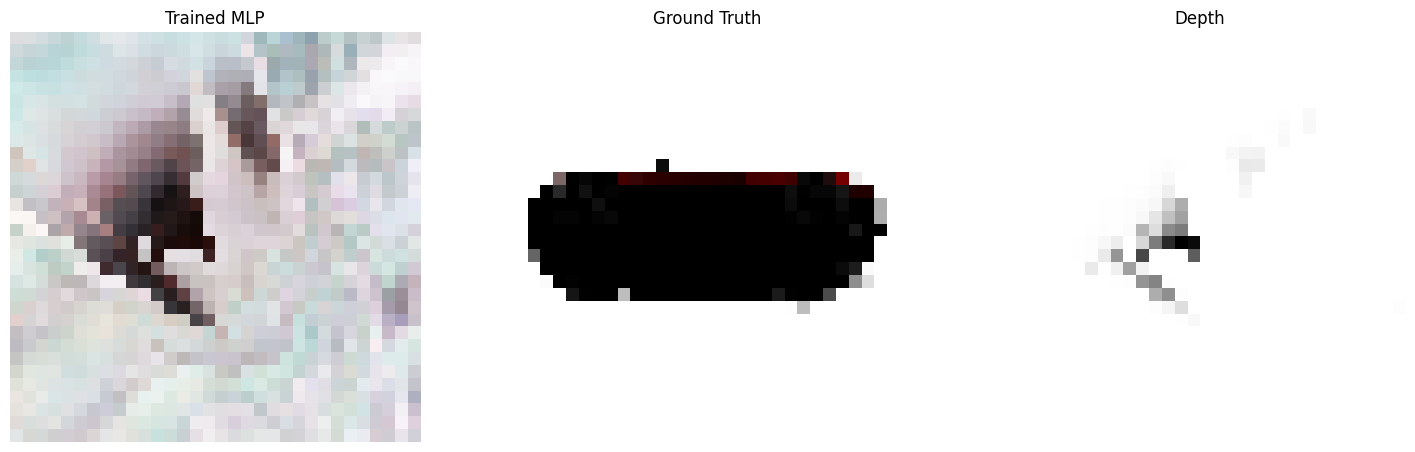

Step 450: loss = 0.06828
same view dir as src


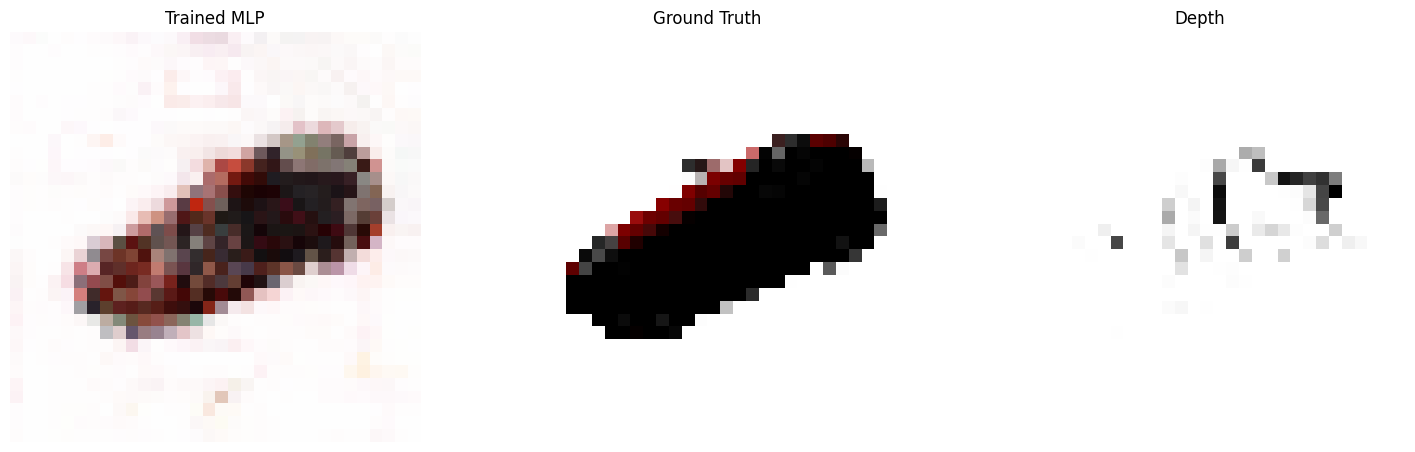

Step 460: loss = 0.05312


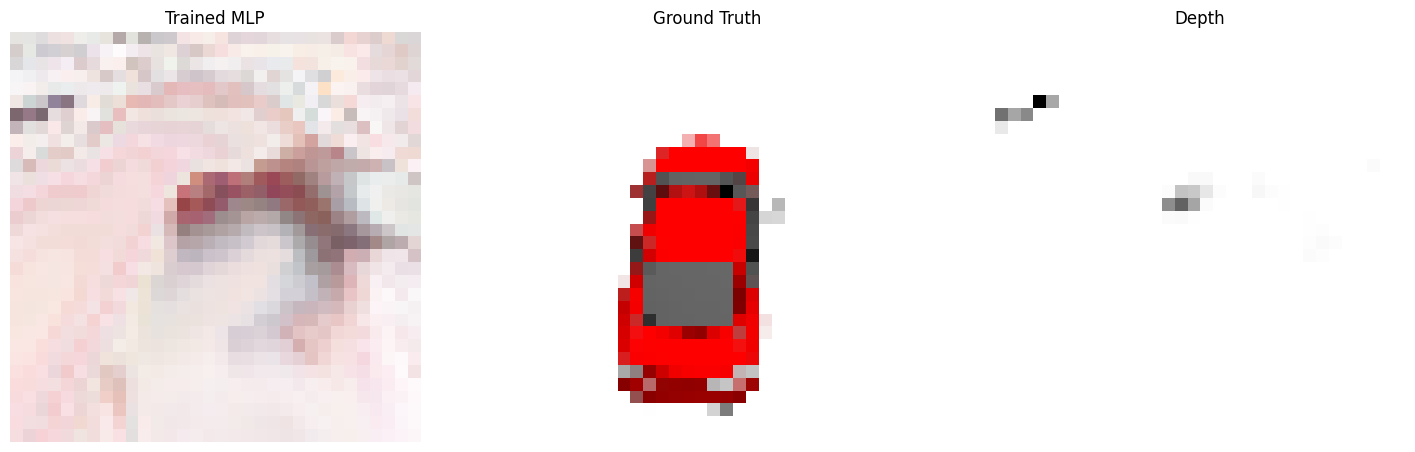

Step 470: loss = 0.12278


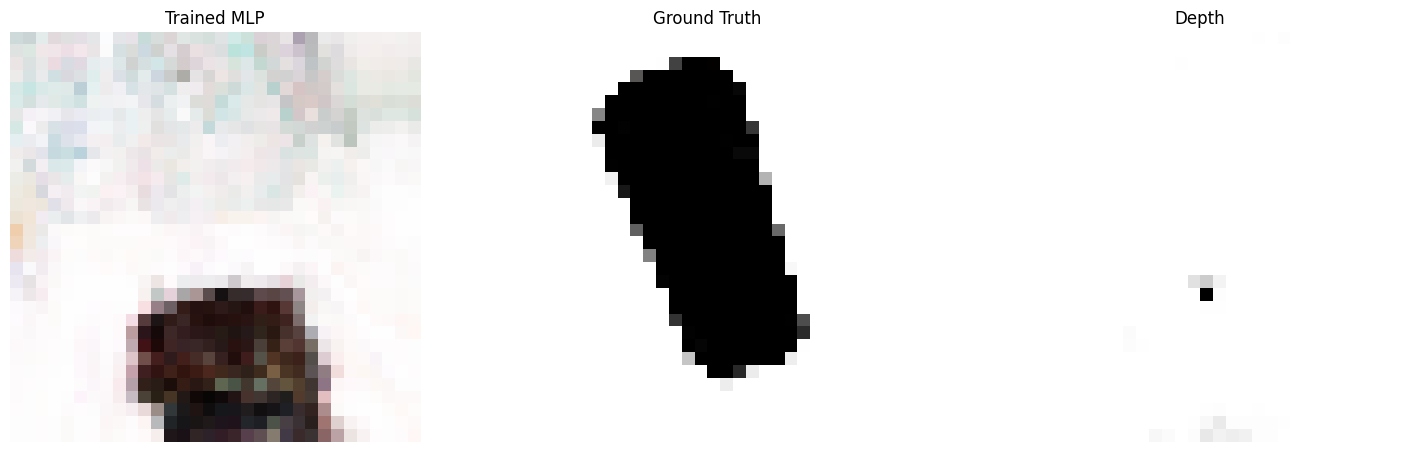

Step 480: loss = 0.06030


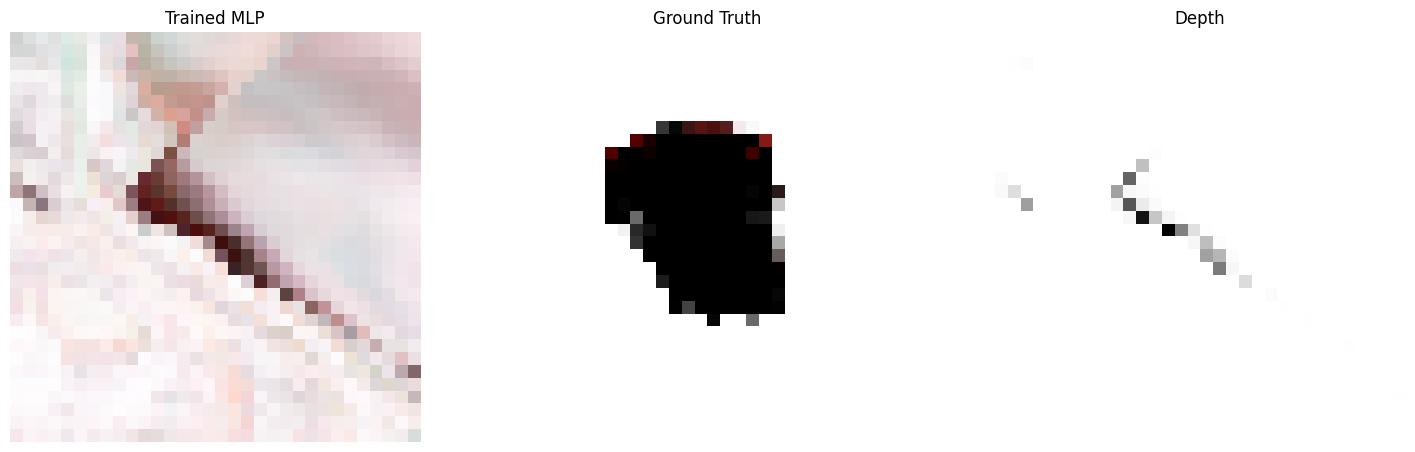

Step 490: loss = 0.06754


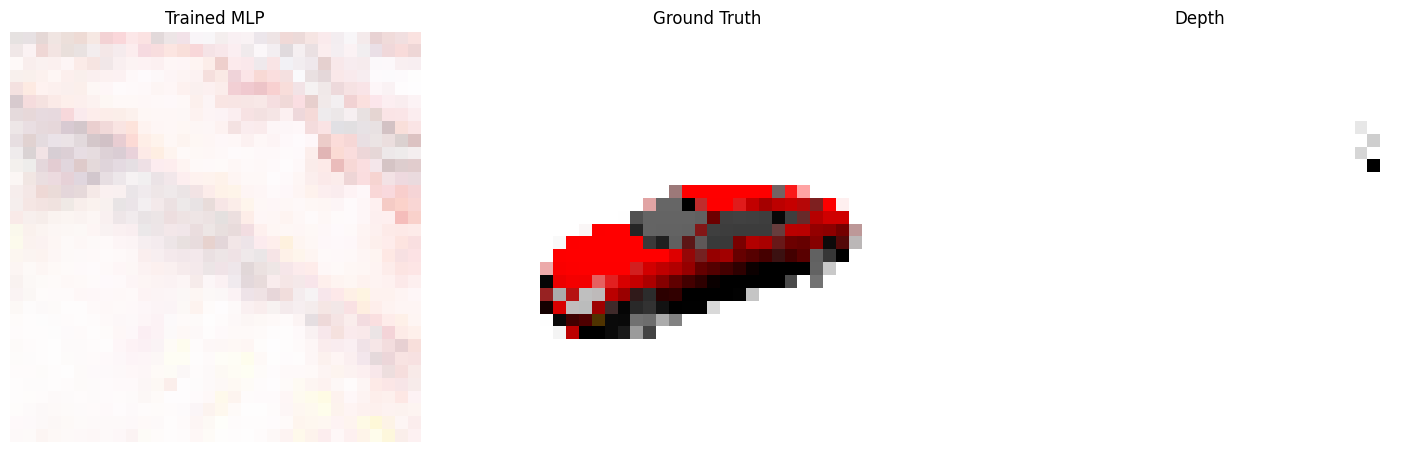

In [7]:
######## TODO
# Test dataset
sl = 32
train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
                                             max_num_instances=1,
                                             max_observations_per_instance=50,
                                             img_sidelength=sl,
                                             specific_observation_idcs=None,
                                             samples_per_instance=2)


train_dataloader = DataLoader(train_dataset,
                                      batch_size=1,
                                      shuffle=True,
                                      drop_last=True,
                                      collate_fn=train_dataset.collate_fn
                                      )

# Configurations
optim = torch.optim.Adam(lr=5e-5, params=rf_and_renderer.parameters())

try:
    _ = fit(net,
        rf_and_renderer, 
        train_dataloader, 
        loss_fn=mse_loss, 
        resolution=(sl, sl, 3), 
        plotting_function=plot_output_ground_truth, 
        optimizer=optim, 
        total_steps=500,
        steps_til_summary=10
        )
except Exception:
    print(traceback.format_exc())


### PixelNeRF + Adaptive Volume Renderer

In [8]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# Create a pixelnerf net
net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# Load pretrianed weights
model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
net.load_weights(model_path)

# Combine with volumerenderer
renderer = AdaptiveVolumeRenderer.from_conf(conf["adaptive_renderer"]).to(
    device=device
)

rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

Using torchvision resnet34 encoder
Load /Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/checkpoints/srn_car/pixel_nerf_latest


In [9]:
######## TODO
# Test dataset
sl = 32
dataset = SRNsCars(f'{root_dir}',max_num_instances=1, img_sidelength=sl)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)

# Configurations
optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

try:
    _ = fit(net,
        rf_and_renderer, 
        iter(data_loader), 
        loss_fn=mse_loss, 
        resolution=(sl, sl, 3), 
        plotting_function=plot_output_ground_truth, 
        optimizer=optim, 
        total_steps=500,
        steps_til_summary=10
        )
except Exception:
    print(traceback.format_exc())


NameError: name 'SRNsCars' is not defined